In [1]:
import torch
import data
import tqdm
import models
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import v2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Loading the configuration file, which contains information about the simulated images, and the telescopes they were modelled on, and some model hyperparameters

In [2]:
with open('../config.json') as config_file:
    config = json.load(config_file)

In [3]:
EPOCHS = 250
LR = 1e-4
IN_SHAPE = config["image_shape"] # image dimensions in pixels (assuming square image)
MAGNIFICATION = config["magnification"] # magnitude of each magnification
N_MAG = config["n_magnification"] # number of magnifications required to be performed
DELTA = config["resolution"] # LR image resolution
alpha_t_scaling = config["alpha_t_scaling"] # scaling coefficient of the tangential component of the deflection angle 
VDL_WEIGHT = 0.5 # initial vdl weight

### Scaling the deflection angle obtained from the SISR models:
The deflection angle values are obtained by design as $\alpha(x,y) \in (0,1)$. They are thus rescaled within appropriate bounds before their use for the purpose of lensing. The coefficients 1 and 2 correspond to the radial $\alpha_r(x,y)$ and tangential $\alpha_t(x,y)$ components of the deflection angle. While $\alpha_r(x,y)$ can ideally be used to contain all the pertaining information, this is no longer required ot be true, as the image space is discretized to pixels. To account for potential inaccuracies brought by this discretization, a (smaller) $\alpha_t(x,y)$ is used for the purpose of potential correction.

In [ ]:
alpha_bounds = [config["alpha_l"],config["alpha_h"]] # bounds for the deflection angle, used in it's scaling

alpha_coeff_1 = torch.tensor(alpha_bounds[1]-alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff_2 = torch.tensor((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff = torch.concat([alpha_coeff_1, alpha_coeff_2],dim=1)

alpha_disp_1 = torch.tensor(alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp_2 = torch.tensor(-((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling)/2).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp = torch.concat([alpha_disp_1, alpha_disp_2],dim=1)

def alpha_scaling(alpha):
    """
    Scales the deflection angle obtained from the model to meaningful bounds
    
    :param alpha: Deflection angle to be scaled
    :return: Scaled deflection angle
    """
    alpha = alpha * alpha_coeff.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    alpha = alpha + alpha_disp.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    return alpha

### Loading the datasets, the dataloaders and performing the required train:validation partitions
A batch size of 5 (merely for computational convenience) is used 5000 images for training, which is divided by an 80:20 validation split. The 5000 images are derived more-or-less equally from the three DM sub-structure classes. There are no high-resolution images loaded as they are not needed !

In [4]:
# We can now load the datasets, combine and shuffle them to have a (close to) homogenous distribution of all sub-structures.
BATCH_SIZE = 5 # Feel free to increase this number; all the training was done on my personal machine, hence, this limitation/
TRAIN_FRACTION = 0.2

dataset_no_sub = data.LensingDataset('../../Simulations/data_model_1/',['no_sub'],5000)
train_dataset_no_sub, val_dataset_no_sub = torch.utils.data.random_split(dataset_no_sub, [0.8, 0.2])

dataset_axion = data.LensingDataset('../../Simulations/data_model_1/',['axion'],5000)
train_dataset_axion, val_dataset_axion = torch.utils.data.random_split(dataset_axion, [0.8, 0.2])

dataset_cdm = data.LensingDataset('../../Simulations/data_model_1/',['cdm'],5000)
train_dataset_cdm, val_dataset_cdm = torch.utils.data.random_split(dataset_cdm, [0.8, 0.2])

train_dataset = torch.utils.data.ConcatDataset([train_dataset_no_sub, train_dataset_axion, train_dataset_cdm])
val_dataset = torch.utils.data.ConcatDataset([val_dataset_no_sub, val_dataset_axion, val_dataset_cdm])

train_dataset, train_rest = torch.utils.data.random_split(train_dataset, [0.34*TRAIN_FRACTION, 1-0.34*TRAIN_FRACTION])
val_dataset, val_rest = torch.utils.data.random_split(val_dataset, [0.34*TRAIN_FRACTION, 1-0.34*TRAIN_FRACTION])

train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

print(f'This configuration will load {len(train_dataset)+len(val_dataset)} (low-resolution) images in total, with an 80:20 validation split.') 

This configuration will load 1020 (low-resolution) images in total, with an 80:20 validation split.


### Defining data-augmentations

In [5]:
transforms = v2.Compose([
    v2.RandomRotation(degrees=(-180,180)),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomHorizontalFlip(p=0.5)
])

### Model and physics-inspired loss function loading

In [6]:
# We construct and load the SISR model to the GPU (if available). A loss module is also loaded that performs all the operations required during training.

alpha_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["alpha_depth"], in_channels=1, latent_channel_count=config["latent_channels"]).to(device)
lens_loss = models.SersicProfiler(resolution=DELTA, device=device, sersic_args = [1, 1, 0.25], vdl_weight=VDL_WEIGHT)

opt = torch.optim.Adam(params=alpha_model.parameters(),lr=LR)
alpha_params = sum(p.numel() for p in alpha_model.parameters())
print(f"Image network parameters: {alpha_params}")

Image network parameters: 900422


### Performing weight initialization
Several studies have shown that model weight initialization can help in more effective convergence.

In [7]:
# Performing He initialization of the model weights.

def init_weights(m):
    """
    Iterates through all the convolution and fully connected layers of the model to initialize all their weights

    :param m: Model to be initialized
    """
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)  # He initialization
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

alpha_model.apply(init_weights)

SISR(
  (residual_layer_list): ModuleList(
    (0-2): 3 x Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (subpixel_layer_list): ModuleList(
    (0): Sequential(
      (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): PixelShuffle(upscale_factor=2)
      (2): ReLU()
    )
  )
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv3): Conv2d(64, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2

### Defining functions that sample the model's performance

In [8]:
def give_random_image(dataset, alpha_model, length, i=None, plot=True):
    """
    Provides a random image for evaluation

    :param dataset: Dataset used
    :param alpha_model: Model used
    :param length: Length of dataset used
    :param i: Index of the selected image, default: 
    :param plot: If true, also plots the source fitting graphs
    :return: original LR image, SR image, reconstructed source
    """
    if i == None:
        i = np.random.randint(low=0,high=length)
    LR = dataset[i].view(1,1,IN_SHAPE,IN_SHAPE)
    alpha = alpha_scaling(alpha_model(LR.float().to(device)).detach())
    sersic_profile, LR, source_profile = lens_loss.get_sample(alpha.to(device), LR.to(device), plot)
    LR_im = Image.fromarray(LR.cpu().detach().numpy()[0]*255)
    sersic_im = Image.fromarray(sersic_profile.cpu().detach().numpy()[0]*255)
    source_im = Image.fromarray(source_profile.cpu().detach().numpy()[0]*255)
    return (LR_im, sersic_im, source_im)

def show_random_image(image_tuple):
    """
    Displays the images provided by the give_random_image function
    
    :param image_tuple: Tuple of images returned by the give_random_image function
    """
    LR_im, sersic_im, source_im = image_tuple[0], image_tuple[1], image_tuple[2]
    plot, axes = plt.subplots(1,3)
    plot.set_size_inches(18,6)
    axes[0].imshow(LR_im)
    axes[1].imshow(sersic_im)
    axes[2].imshow(source_im)
    axes[0].set_title("LR_interpolated")
    axes[1].set_title("Image")
    axes[2].set_title("Source Profile")

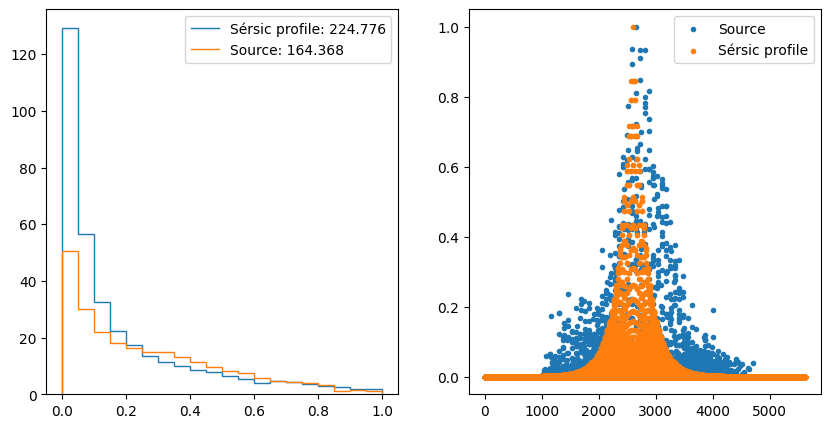

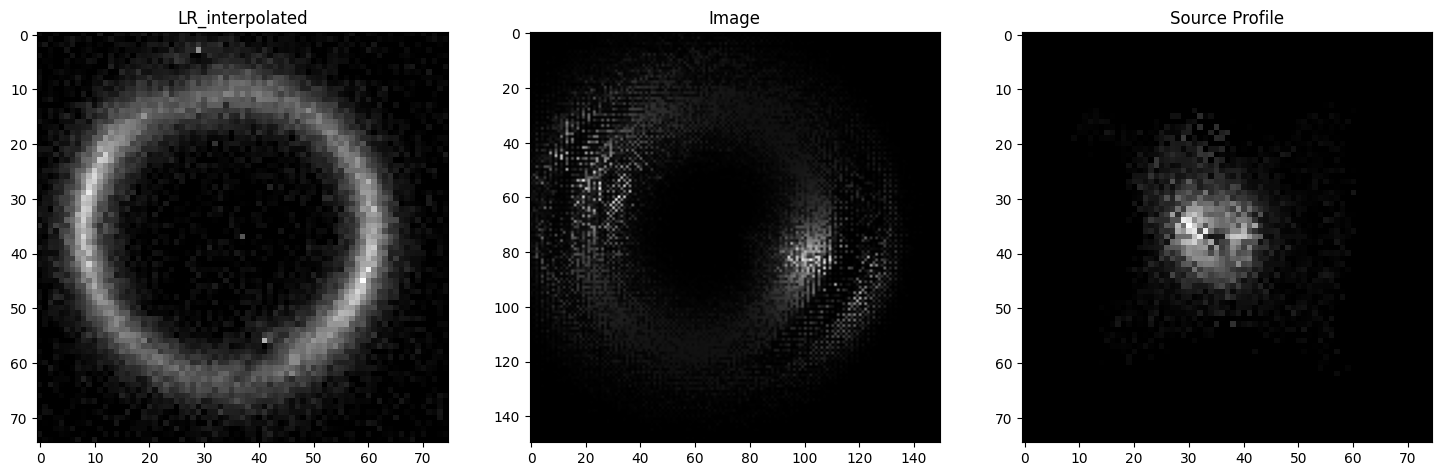

In [9]:
show_random_image(give_random_image(val_dataset, alpha_model, len(val_dataset)))

### The training sequence
The model is trained over the set number of epochs over the training images, and subsequently validated on the validation set. For both, the deflection angle given by the model is used to perform lensing, and is trained in an unsupervised manner by imposing the lensing system's constraints. Since the loss module is composed of various components, each of them is tracked for further study if required. In addition, the training process is stored as GIFs of the SR images, the LR images, and the reconstructed source.

In [10]:
# Training Sequence

best_val_loss = np.inf
best_weights = None
history = {'pre_loss':[],'val_loss':[], 'loss':[], 'images':[], 'lr':[], 'source':[]} # tracks the train and val losses and training results at each epoch
history_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]} # tracks the individual train loss components at each epoch
for epoch in range(EPOCHS):
    losses = []
    alpha_model.train()
    individual_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]}
    for i,(x) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Training epoch {epoch+1}")):
        (x) = (transforms(x.float().to(device)))
        alpha = alpha_model(x)
        alpha = alpha_scaling(alpha)
        loss, history_individual = lens_loss(alpha, x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(float(loss))
        for key in individual_losses.keys():
            if history_individual[key] != None:
                individual_losses[key].append(float(history_individual[key]))
            else:
                individual_losses[key].append(None)
    for key in individual_losses.keys():
        if individual_losses[key][-1] != None:
            history_losses[key].append(np.mean(individual_losses[key]))
        else:
            history_losses[key].append(None)
    if np.isnan(losses[-1]): 
        break
    print(f"Training at epoch {epoch+1}/{EPOCHS}: {np.mean(losses) - float(np.mean(individual_losses['alpha_0']))} at LR={opt.param_groups[0]['lr']}")
    history['loss'].append(np.mean(losses) - float(np.mean(individual_losses['alpha_0'])))
    alpha_model.eval()
    individual_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]}
    losses = []
    for i,(x) in enumerate(tqdm.tqdm(val_dataloader, desc=f"Validation epoch {epoch+1}")):
        (x) = (transforms(x.float().to(device)))
        alpha = alpha_scaling(alpha_model(x))
        val_loss, history_individual = lens_loss(alpha, x)
        losses.append(float(val_loss))
        for key in individual_losses.keys():
            if history_individual[key] != None:
                individual_losses[key].append(float(history_individual[key]))
            else:
                individual_losses[key].append(None)
    if best_val_loss > np.mean(losses):
        best_val_loss = np.mean(losses)
        best_weights = alpha_model.state_dict()
    history['val_loss'].append(np.mean(losses) - float(np.mean(individual_losses['alpha_0'])))
    print(f"Validation at epoch {epoch+1}/{EPOCHS}: {np.mean(losses) - float(np.mean(individual_losses['alpha_0']))} at LR={opt.param_groups[0]['lr']}")
    lr, im, sr = give_random_image(val_dataset, alpha_model, len(val_dataset),50, plot=False)
    history['lr'].append(lr)
    history['images'].append(im)
    history['source'].append(sr)

Training epoch 1: 100%|██████████| 164/164 [00:11<00:00, 14.48it/s]


Training at epoch 1/250: 0.035787329878430904 at LR=0.0001


Validation epoch 1: 100%|██████████| 41/41 [00:01<00:00, 23.74it/s]


Validation at epoch 1/250: 0.036782996047560766 at LR=0.0001


Training epoch 2: 100%|██████████| 164/164 [00:10<00:00, 15.10it/s]


Training at epoch 2/250: 0.03545563869042004 at LR=0.0001


Validation epoch 2: 100%|██████████| 41/41 [00:01<00:00, 25.07it/s]


Validation at epoch 2/250: 0.035284508519419805 at LR=0.0001


Training epoch 3: 100%|██████████| 164/164 [00:10<00:00, 15.04it/s]


Training at epoch 3/250: 0.03467711390609421 at LR=0.0001


Validation epoch 3: 100%|██████████| 41/41 [00:01<00:00, 25.44it/s]


Validation at epoch 3/250: 0.03503575934687765 at LR=0.0001


Training epoch 4: 100%|██████████| 164/164 [00:10<00:00, 14.99it/s]


Training at epoch 4/250: 0.030772595870785596 at LR=0.0001


Validation epoch 4: 100%|██████████| 41/41 [00:01<00:00, 24.88it/s]


Validation at epoch 4/250: 0.02919347593333663 at LR=0.0001


Training epoch 5: 100%|██████████| 164/164 [00:10<00:00, 15.05it/s]


Training at epoch 5/250: 0.026847515534893493 at LR=0.0001


Validation epoch 5: 100%|██████████| 41/41 [00:01<00:00, 24.72it/s]


Validation at epoch 5/250: 0.027511157867748565 at LR=0.0001


Training epoch 6: 100%|██████████| 164/164 [00:10<00:00, 14.93it/s]


Training at epoch 6/250: 0.026148235666701887 at LR=0.0001


Validation epoch 6: 100%|██████████| 41/41 [00:01<00:00, 25.22it/s]


Validation at epoch 6/250: 0.024551888848314198 at LR=0.0001


Training epoch 7: 100%|██████████| 164/164 [00:11<00:00, 14.86it/s]


Training at epoch 7/250: 0.025243190909372416 at LR=0.0001


Validation epoch 7: 100%|██████████| 41/41 [00:01<00:00, 25.55it/s]


Validation at epoch 7/250: 0.024213822689134537 at LR=0.0001


Training epoch 8: 100%|██████████| 164/164 [00:10<00:00, 14.96it/s]


Training at epoch 8/250: 0.024537296656223874 at LR=0.0001


Validation epoch 8: 100%|██████████| 41/41 [00:01<00:00, 25.35it/s]


Validation at epoch 8/250: 0.026714248094344285 at LR=0.0001


Training epoch 9: 100%|██████████| 164/164 [00:10<00:00, 15.15it/s]


Training at epoch 9/250: 0.024129737387184148 at LR=0.0001


Validation epoch 9: 100%|██████████| 41/41 [00:01<00:00, 24.84it/s]


Validation at epoch 9/250: 0.025251320222528968 at LR=0.0001


Training epoch 10: 100%|██████████| 164/164 [00:10<00:00, 14.92it/s]


Training at epoch 10/250: 0.023669112876920802 at LR=0.0001


Validation epoch 10: 100%|██████████| 41/41 [00:01<00:00, 24.74it/s]


Validation at epoch 10/250: 0.0245344354203198 at LR=0.0001


Training epoch 11: 100%|██████████| 164/164 [00:11<00:00, 14.89it/s]


Training at epoch 11/250: 0.02316492769963721 at LR=0.0001


Validation epoch 11: 100%|██████████| 41/41 [00:01<00:00, 25.15it/s]


Validation at epoch 11/250: 0.022818166890363322 at LR=0.0001


Training epoch 12: 100%|██████████| 164/164 [00:10<00:00, 15.06it/s]


Training at epoch 12/250: 0.02287343168125783 at LR=0.0001


Validation epoch 12: 100%|██████████| 41/41 [00:01<00:00, 24.47it/s]


Validation at epoch 12/250: 0.023011389373029333 at LR=0.0001


Training epoch 13: 100%|██████████| 164/164 [00:10<00:00, 14.93it/s]


Training at epoch 13/250: 0.02228056657605055 at LR=0.0001


Validation epoch 13: 100%|██████████| 41/41 [00:01<00:00, 25.06it/s]


Validation at epoch 13/250: 0.024076639311160986 at LR=0.0001


Training epoch 14: 100%|██████████| 164/164 [00:11<00:00, 14.83it/s]


Training at epoch 14/250: 0.022219095193133576 at LR=0.0001


Validation epoch 14: 100%|██████████| 41/41 [00:01<00:00, 24.74it/s]


Validation at epoch 14/250: 0.02264348617130209 at LR=0.0001


Training epoch 15: 100%|██████████| 164/164 [00:10<00:00, 14.93it/s]


Training at epoch 15/250: 0.021580197469319964 at LR=0.0001


Validation epoch 15: 100%|██████████| 41/41 [00:01<00:00, 25.15it/s]


Validation at epoch 15/250: 0.0210834479828297 at LR=0.0001


Training epoch 16: 100%|██████████| 164/164 [00:11<00:00, 14.90it/s]


Training at epoch 16/250: 0.021204524975917415 at LR=0.0001


Validation epoch 16: 100%|██████████| 41/41 [00:01<00:00, 25.15it/s]


Validation at epoch 16/250: 0.020925757642721803 at LR=0.0001


Training epoch 17: 100%|██████████| 164/164 [00:10<00:00, 14.91it/s]


Training at epoch 17/250: 0.021385828244624795 at LR=0.0001


Validation epoch 17: 100%|██████████| 41/41 [00:01<00:00, 24.80it/s]


Validation at epoch 17/250: 0.03191639573835745 at LR=0.0001


Training epoch 18: 100%|██████████| 164/164 [00:11<00:00, 14.78it/s]


Training at epoch 18/250: 0.023797209696878294 at LR=0.0001


Validation epoch 18: 100%|██████████| 41/41 [00:01<00:00, 24.61it/s]


Validation at epoch 18/250: 0.02142085727281505 at LR=0.0001


Training epoch 19: 100%|██████████| 164/164 [00:11<00:00, 14.87it/s]


Training at epoch 19/250: 0.02115789069311421 at LR=0.0001


Validation epoch 19: 100%|██████████| 41/41 [00:01<00:00, 24.72it/s]


Validation at epoch 19/250: 0.020318178292477458 at LR=0.0001


Training epoch 20: 100%|██████████| 164/164 [00:11<00:00, 14.82it/s]


Training at epoch 20/250: 0.019888757215528862 at LR=0.0001


Validation epoch 20: 100%|██████████| 41/41 [00:01<00:00, 25.08it/s]


Validation at epoch 20/250: 0.019521381822414696 at LR=0.0001


Training epoch 21: 100%|██████████| 164/164 [00:11<00:00, 14.82it/s]


Training at epoch 21/250: 0.01896161734972649 at LR=0.0001


Validation epoch 21: 100%|██████████| 41/41 [00:01<00:00, 24.68it/s]


Validation at epoch 21/250: 0.018956594708625502 at LR=0.0001


Training epoch 22: 100%|██████████| 164/164 [00:11<00:00, 14.77it/s]


Training at epoch 22/250: 0.01862657227036657 at LR=0.0001


Validation epoch 22: 100%|██████████| 41/41 [00:01<00:00, 24.72it/s]


Validation at epoch 22/250: 0.019267943781437126 at LR=0.0001


Training epoch 23: 100%|██████████| 164/164 [00:10<00:00, 14.91it/s]


Training at epoch 23/250: 0.018345304182730615 at LR=0.0001


Validation epoch 23: 100%|██████████| 41/41 [00:01<00:00, 24.88it/s]


Validation at epoch 23/250: 0.018864784230727977 at LR=0.0001


Training epoch 24: 100%|██████████| 164/164 [00:11<00:00, 14.89it/s]


Training at epoch 24/250: 0.01764059359940314 at LR=0.0001


Validation epoch 24: 100%|██████████| 41/41 [00:01<00:00, 25.12it/s]


Validation at epoch 24/250: 0.017638550947772384 at LR=0.0001


Training epoch 25: 100%|██████████| 164/164 [00:11<00:00, 14.75it/s]


Training at epoch 25/250: 0.017502921614966287 at LR=0.0001


Validation epoch 25: 100%|██████████| 41/41 [00:01<00:00, 24.20it/s]


Validation at epoch 25/250: 0.017573488998317684 at LR=0.0001


Training epoch 26: 100%|██████████| 164/164 [00:11<00:00, 14.83it/s]


Training at epoch 26/250: 0.016751916242888333 at LR=0.0001


Validation epoch 26: 100%|██████████| 41/41 [00:01<00:00, 24.40it/s]


Validation at epoch 26/250: 0.017363223438889425 at LR=0.0001


Training epoch 27: 100%|██████████| 164/164 [00:11<00:00, 14.73it/s]


Training at epoch 27/250: 0.016719142134761347 at LR=0.0001


Validation epoch 27: 100%|██████████| 41/41 [00:01<00:00, 24.40it/s]


Validation at epoch 27/250: 0.016738558151168613 at LR=0.0001


Training epoch 28: 100%|██████████| 164/164 [00:11<00:00, 14.82it/s]


Training at epoch 28/250: 0.016125795163111988 at LR=0.0001


Validation epoch 28: 100%|██████████| 41/41 [00:01<00:00, 24.95it/s]


Validation at epoch 28/250: 0.016305077023145445 at LR=0.0001


Training epoch 29: 100%|██████████| 164/164 [00:11<00:00, 14.81it/s]


Training at epoch 29/250: 0.015801744600161684 at LR=0.0001


Validation epoch 29: 100%|██████████| 41/41 [00:01<00:00, 24.38it/s]


Validation at epoch 29/250: 0.016093110836042864 at LR=0.0001


Training epoch 30: 100%|██████████| 164/164 [00:11<00:00, 14.64it/s]


Training at epoch 30/250: 0.015316118090839421 at LR=0.0001


Validation epoch 30: 100%|██████████| 41/41 [00:01<00:00, 24.35it/s]


Validation at epoch 30/250: 0.015285616502074934 at LR=0.0001


Training epoch 31: 100%|██████████| 164/164 [00:11<00:00, 14.74it/s]


Training at epoch 31/250: 0.014733838588964739 at LR=0.0001


Validation epoch 31: 100%|██████████| 41/41 [00:01<00:00, 24.71it/s]


Validation at epoch 31/250: 0.014567019287269653 at LR=0.0001


Training epoch 32: 100%|██████████| 164/164 [00:11<00:00, 14.82it/s]


Training at epoch 32/250: 0.014494491648780774 at LR=0.0001


Validation epoch 32: 100%|██████████| 41/41 [00:01<00:00, 25.01it/s]


Validation at epoch 32/250: 0.014484606169323186 at LR=0.0001


Training epoch 33: 100%|██████████| 164/164 [00:11<00:00, 14.71it/s]


Training at epoch 33/250: 0.014315262600841998 at LR=0.0001


Validation epoch 33: 100%|██████████| 41/41 [00:01<00:00, 24.87it/s]


Validation at epoch 33/250: 0.014669281691767093 at LR=0.0001


Training epoch 34: 100%|██████████| 164/164 [00:11<00:00, 14.69it/s]


Training at epoch 34/250: 0.013702645230961668 at LR=0.0001


Validation epoch 34: 100%|██████████| 41/41 [00:01<00:00, 24.88it/s]


Validation at epoch 34/250: 0.014669332986913346 at LR=0.0001


Training epoch 35: 100%|██████████| 164/164 [00:11<00:00, 14.84it/s]


Training at epoch 35/250: 0.01337651125930545 at LR=0.0001


Validation epoch 35: 100%|██████████| 41/41 [00:01<00:00, 24.73it/s]


Validation at epoch 35/250: 0.013031800308054675 at LR=0.0001


Training epoch 36: 100%|██████████| 164/164 [00:11<00:00, 14.76it/s]


Training at epoch 36/250: 0.012814885923900166 at LR=0.0001


Validation epoch 36: 100%|██████████| 41/41 [00:01<00:00, 24.61it/s]


Validation at epoch 36/250: 0.012831462147537755 at LR=0.0001


Training epoch 37: 100%|██████████| 164/164 [00:11<00:00, 14.68it/s]


Training at epoch 37/250: 0.01233754790439157 at LR=0.0001


Validation epoch 37: 100%|██████████| 41/41 [00:01<00:00, 24.62it/s]


Validation at epoch 37/250: 0.01250129560201724 at LR=0.0001


Training epoch 38: 100%|██████████| 164/164 [00:11<00:00, 14.66it/s]


Training at epoch 38/250: 0.01188296246379273 at LR=0.0001


Validation epoch 38: 100%|██████████| 41/41 [00:01<00:00, 24.05it/s]


Validation at epoch 38/250: 0.012107699598390155 at LR=0.0001


Training epoch 39: 100%|██████████| 164/164 [00:11<00:00, 14.65it/s]


Training at epoch 39/250: 0.011639514903214236 at LR=0.0001


Validation epoch 39: 100%|██████████| 41/41 [00:01<00:00, 24.00it/s]


Validation at epoch 39/250: 0.011363434622336814 at LR=0.0001


Training epoch 40: 100%|██████████| 164/164 [00:11<00:00, 14.51it/s]


Training at epoch 40/250: 0.011159164571947214 at LR=0.0001


Validation epoch 40: 100%|██████████| 41/41 [00:01<00:00, 24.40it/s]


Validation at epoch 40/250: 0.011525699298079239 at LR=0.0001


Training epoch 41: 100%|██████████| 164/164 [00:11<00:00, 14.69it/s]


Training at epoch 41/250: 0.010826629033899957 at LR=0.0001


Validation epoch 41: 100%|██████████| 41/41 [00:01<00:00, 24.52it/s]


Validation at epoch 41/250: 0.010901842784511333 at LR=0.0001


Training epoch 42: 100%|██████████| 164/164 [00:11<00:00, 14.67it/s]


Training at epoch 42/250: 0.01030591523300334 at LR=0.0001


Validation epoch 42: 100%|██████████| 41/41 [00:01<00:00, 24.07it/s]


Validation at epoch 42/250: 0.010236742961640673 at LR=0.0001


Training epoch 43: 100%|██████████| 164/164 [00:11<00:00, 14.75it/s]


Training at epoch 43/250: 0.00980078181849577 at LR=0.0001


Validation epoch 43: 100%|██████████| 41/41 [00:01<00:00, 23.75it/s]


Validation at epoch 43/250: 0.010291061469172014 at LR=0.0001


Training epoch 44: 100%|██████████| 164/164 [00:11<00:00, 14.70it/s]


Training at epoch 44/250: 0.009333471962812971 at LR=0.0001


Validation epoch 44: 100%|██████████| 41/41 [00:01<00:00, 24.04it/s]


Validation at epoch 44/250: 0.0106769656100901 at LR=0.0001


Training epoch 45: 100%|██████████| 164/164 [00:11<00:00, 14.74it/s]


Training at epoch 45/250: 0.00909541232125243 at LR=0.0001


Validation epoch 45: 100%|██████████| 41/41 [00:01<00:00, 23.85it/s]


Validation at epoch 45/250: 0.009089127812597037 at LR=0.0001


Training epoch 46: 100%|██████████| 164/164 [00:11<00:00, 14.67it/s]


Training at epoch 46/250: 0.00890938022774474 at LR=0.0001


Validation epoch 46: 100%|██████████| 41/41 [00:01<00:00, 24.12it/s]


Validation at epoch 46/250: 0.008736833103395795 at LR=0.0001


Training epoch 47: 100%|██████████| 164/164 [00:11<00:00, 14.60it/s]


Training at epoch 47/250: 0.010686960930953076 at LR=0.0001


Validation epoch 47: 100%|██████████| 41/41 [00:01<00:00, 24.38it/s]


Validation at epoch 47/250: 0.009237516307976187 at LR=0.0001


Training epoch 48: 100%|██████████| 164/164 [00:11<00:00, 14.73it/s]


Training at epoch 48/250: 0.00877348103038058 at LR=0.0001


Validation epoch 48: 100%|██████████| 41/41 [00:01<00:00, 24.05it/s]


Validation at epoch 48/250: 0.008803644992706434 at LR=0.0001


Training epoch 49: 100%|██████████| 164/164 [00:11<00:00, 14.60it/s]


Training at epoch 49/250: 0.00820919079351148 at LR=0.0001


Validation epoch 49: 100%|██████████| 41/41 [00:01<00:00, 24.07it/s]


Validation at epoch 49/250: 0.00801112662387512 at LR=0.0001


Training epoch 50: 100%|██████████| 164/164 [00:11<00:00, 14.64it/s]


Training at epoch 50/250: 0.0076216358014257485 at LR=0.0001


Validation epoch 50: 100%|██████████| 41/41 [00:01<00:00, 24.44it/s]


Validation at epoch 50/250: 0.00786052360100013 at LR=0.0001


Training epoch 51: 100%|██████████| 164/164 [00:11<00:00, 14.57it/s]


Training at epoch 51/250: 0.007501619219887866 at LR=0.0001


Validation epoch 51: 100%|██████████| 41/41 [00:01<00:00, 24.40it/s]


Validation at epoch 51/250: 0.007380678143817931 at LR=0.0001


Training epoch 52: 100%|██████████| 164/164 [00:11<00:00, 14.74it/s]


Training at epoch 52/250: 0.00761901620539791 at LR=0.0001


Validation epoch 52: 100%|██████████| 41/41 [00:01<00:00, 23.99it/s]


Validation at epoch 52/250: 0.007392044474438923 at LR=0.0001


Training epoch 53: 100%|██████████| 164/164 [00:11<00:00, 14.58it/s]


Training at epoch 53/250: 0.007712284233648239 at LR=0.0001


Validation epoch 53: 100%|██████████| 41/41 [00:01<00:00, 23.94it/s]


Validation at epoch 53/250: 0.0073268222125678715 at LR=0.0001


Training epoch 54: 100%|██████████| 164/164 [00:11<00:00, 14.56it/s]


Training at epoch 54/250: 0.006972262057299702 at LR=0.0001


Validation epoch 54: 100%|██████████| 41/41 [00:01<00:00, 23.77it/s]


Validation at epoch 54/250: 0.0071091397740685085 at LR=0.0001


Training epoch 55: 100%|██████████| 164/164 [00:11<00:00, 14.67it/s]


Training at epoch 55/250: 0.006604846443401696 at LR=0.0001


Validation epoch 55: 100%|██████████| 41/41 [00:01<00:00, 23.68it/s]


Validation at epoch 55/250: 0.006589034088126315 at LR=0.0001


Training epoch 56: 100%|██████████| 164/164 [00:11<00:00, 14.65it/s]


Training at epoch 56/250: 0.006362929529930669 at LR=0.0001


Validation epoch 56: 100%|██████████| 41/41 [00:01<00:00, 24.27it/s]


Validation at epoch 56/250: 0.006494758082071047 at LR=0.0001


Training epoch 57: 100%|██████████| 164/164 [00:11<00:00, 14.64it/s]


Training at epoch 57/250: 0.006260302927197389 at LR=0.0001


Validation epoch 57: 100%|██████████| 41/41 [00:01<00:00, 23.65it/s]


Validation at epoch 57/250: 0.006973121644611039 at LR=0.0001


Training epoch 58: 100%|██████████| 164/164 [00:11<00:00, 14.69it/s]


Training at epoch 58/250: 0.006711772386774012 at LR=0.0001


Validation epoch 58: 100%|██████████| 41/41 [00:01<00:00, 24.02it/s]


Validation at epoch 58/250: 0.006197659782894955 at LR=0.0001


Training epoch 59: 100%|██████████| 164/164 [00:11<00:00, 14.60it/s]


Training at epoch 59/250: 0.006164844903140897 at LR=0.0001


Validation epoch 59: 100%|██████████| 41/41 [00:01<00:00, 24.48it/s]


Validation at epoch 59/250: 0.00614175071269728 at LR=0.0001


Training epoch 60: 100%|██████████| 164/164 [00:11<00:00, 14.61it/s]


Training at epoch 60/250: 0.006016280671025104 at LR=0.0001


Validation epoch 60: 100%|██████████| 41/41 [00:01<00:00, 24.47it/s]


Validation at epoch 60/250: 0.006035546269608526 at LR=0.0001


Training epoch 61: 100%|██████████| 164/164 [00:11<00:00, 14.61it/s]


Training at epoch 61/250: 0.005836869689363351 at LR=0.0001


Validation epoch 61: 100%|██████████| 41/41 [00:01<00:00, 23.18it/s]


Validation at epoch 61/250: 0.006154096868491119 at LR=0.0001


Training epoch 62: 100%|██████████| 164/164 [00:11<00:00, 14.57it/s]


Training at epoch 62/250: 0.005661102145961371 at LR=0.0001


Validation epoch 62: 100%|██████████| 41/41 [00:01<00:00, 24.71it/s]


Validation at epoch 62/250: 0.005672379403599401 at LR=0.0001


Training epoch 63: 100%|██████████| 164/164 [00:11<00:00, 14.66it/s]


Training at epoch 63/250: 0.006415862128672348 at LR=0.0001


Validation epoch 63: 100%|██████████| 41/41 [00:01<00:00, 24.39it/s]


Validation at epoch 63/250: 0.005885765694362883 at LR=0.0001


Training epoch 64: 100%|██████████| 164/164 [00:11<00:00, 14.55it/s]


Training at epoch 64/250: 0.005721686542795108 at LR=0.0001


Validation epoch 64: 100%|██████████| 41/41 [00:01<00:00, 24.56it/s]


Validation at epoch 64/250: 0.005804768179098951 at LR=0.0001


Training epoch 65: 100%|██████████| 164/164 [00:11<00:00, 14.56it/s]


Training at epoch 65/250: 0.005511113310093628 at LR=0.0001


Validation epoch 65: 100%|██████████| 41/41 [00:01<00:00, 24.17it/s]


Validation at epoch 65/250: 0.006365286903640414 at LR=0.0001


Training epoch 66: 100%|██████████| 164/164 [00:11<00:00, 14.54it/s]


Training at epoch 66/250: 0.005483610029886022 at LR=0.0001


Validation epoch 66: 100%|██████████| 41/41 [00:01<00:00, 23.55it/s]


Validation at epoch 66/250: 0.006004455079120106 at LR=0.0001


Training epoch 67: 100%|██████████| 164/164 [00:11<00:00, 14.50it/s]


Training at epoch 67/250: 0.006332862440769265 at LR=0.0001


Validation epoch 67: 100%|██████████| 41/41 [00:01<00:00, 24.00it/s]


Validation at epoch 67/250: 0.005938467022000312 at LR=0.0001


Training epoch 68: 100%|██████████| 164/164 [00:11<00:00, 14.71it/s]


Training at epoch 68/250: 0.005838617828685971 at LR=0.0001


Validation epoch 68: 100%|██████████| 41/41 [00:01<00:00, 24.81it/s]


Validation at epoch 68/250: 0.005663830985701302 at LR=0.0001


Training epoch 69: 100%|██████████| 164/164 [00:11<00:00, 14.44it/s]


Training at epoch 69/250: 0.005813087623498243 at LR=0.0001


Validation epoch 69: 100%|██████████| 41/41 [00:01<00:00, 24.54it/s]


Validation at epoch 69/250: 0.005517965645483899 at LR=0.0001


Training epoch 70: 100%|██████████| 164/164 [00:11<00:00, 14.66it/s]


Training at epoch 70/250: 0.005341408654292137 at LR=0.0001


Validation epoch 70: 100%|██████████| 41/41 [00:01<00:00, 24.04it/s]


Validation at epoch 70/250: 0.00545034077261268 at LR=0.0001


Training epoch 71: 100%|██████████| 164/164 [00:11<00:00, 14.62it/s]


Training at epoch 71/250: 0.005422680033938733 at LR=0.0001


Validation epoch 71: 100%|██████████| 41/41 [00:01<00:00, 24.19it/s]


Validation at epoch 71/250: 0.005312035091664278 at LR=0.0001


Training epoch 72: 100%|██████████| 164/164 [00:11<00:00, 14.61it/s]


Training at epoch 72/250: 0.005778795251943648 at LR=0.0001


Validation epoch 72: 100%|██████████| 41/41 [00:01<00:00, 23.97it/s]


Validation at epoch 72/250: 0.0058658764855197935 at LR=0.0001


Training epoch 73: 100%|██████████| 164/164 [00:11<00:00, 14.60it/s]


Training at epoch 73/250: 0.005470568741524092 at LR=0.0001


Validation epoch 73: 100%|██████████| 41/41 [00:01<00:00, 23.41it/s]


Validation at epoch 73/250: 0.00553445500412547 at LR=0.0001


Training epoch 74: 100%|██████████| 164/164 [00:11<00:00, 14.50it/s]


Training at epoch 74/250: 0.005370338370018389 at LR=0.0001


Validation epoch 74: 100%|██████████| 41/41 [00:01<00:00, 24.65it/s]


Validation at epoch 74/250: 0.005667430132900069 at LR=0.0001


Training epoch 75: 100%|██████████| 164/164 [00:11<00:00, 14.43it/s]


Training at epoch 75/250: 0.005405006089060364 at LR=0.0001


Validation epoch 75: 100%|██████████| 41/41 [00:01<00:00, 24.22it/s]


Validation at epoch 75/250: 0.005527025469147214 at LR=0.0001


Training epoch 76: 100%|██████████| 164/164 [00:11<00:00, 14.68it/s]


Training at epoch 76/250: 0.005487534012389938 at LR=0.0001


Validation epoch 76: 100%|██████████| 41/41 [00:01<00:00, 24.69it/s]


Validation at epoch 76/250: 0.005509788668771252 at LR=0.0001


Training epoch 77: 100%|██████████| 164/164 [00:11<00:00, 14.61it/s]


Training at epoch 77/250: 0.005264479142724446 at LR=0.0001


Validation epoch 77: 100%|██████████| 41/41 [00:01<00:00, 23.22it/s]


Validation at epoch 77/250: 0.005302747219613549 at LR=0.0001


Training epoch 78: 100%|██████████| 164/164 [00:11<00:00, 14.49it/s]


Training at epoch 78/250: 0.005256151348542673 at LR=0.0001


Validation epoch 78: 100%|██████████| 41/41 [00:01<00:00, 24.63it/s]


Validation at epoch 78/250: 0.0052798466179122365 at LR=0.0001


Training epoch 79: 100%|██████████| 164/164 [00:11<00:00, 14.67it/s]


Training at epoch 79/250: 0.005271922187913755 at LR=0.0001


Validation epoch 79: 100%|██████████| 41/41 [00:01<00:00, 24.29it/s]


Validation at epoch 79/250: 0.007518367909985344 at LR=0.0001


Training epoch 80: 100%|██████████| 164/164 [00:11<00:00, 14.57it/s]


Training at epoch 80/250: 0.005754230776801705 at LR=0.0001


Validation epoch 80: 100%|██████████| 41/41 [00:01<00:00, 24.58it/s]


Validation at epoch 80/250: 0.005739902390703763 at LR=0.0001


Training epoch 81: 100%|██████████| 164/164 [00:11<00:00, 14.63it/s]


Training at epoch 81/250: 0.005635614508674934 at LR=0.0001


Validation epoch 81: 100%|██████████| 41/41 [00:01<00:00, 24.27it/s]


Validation at epoch 81/250: 0.005336057774867386 at LR=0.0001


Training epoch 82: 100%|██████████| 164/164 [00:11<00:00, 14.55it/s]


Training at epoch 82/250: 0.005411705630405512 at LR=0.0001


Validation epoch 82: 100%|██████████| 41/41 [00:01<00:00, 24.44it/s]


Validation at epoch 82/250: 0.006577930526407549 at LR=0.0001


Training epoch 83: 100%|██████████| 164/164 [00:11<00:00, 14.55it/s]


Training at epoch 83/250: 0.00567248237614588 at LR=0.0001


Validation epoch 83: 100%|██████████| 41/41 [00:01<00:00, 23.94it/s]


Validation at epoch 83/250: 0.006214652045788926 at LR=0.0001


Training epoch 84: 100%|██████████| 164/164 [00:11<00:00, 14.62it/s]


Training at epoch 84/250: 0.006207359741759917 at LR=0.0001


Validation epoch 84: 100%|██████████| 41/41 [00:01<00:00, 23.93it/s]


Validation at epoch 84/250: 0.005840100997153147 at LR=0.0001


Training epoch 85: 100%|██████████| 164/164 [00:11<00:00, 14.65it/s]


Training at epoch 85/250: 0.00579554050601451 at LR=0.0001


Validation epoch 85: 100%|██████████| 41/41 [00:01<00:00, 23.74it/s]


Validation at epoch 85/250: 0.005294095912221364 at LR=0.0001


Training epoch 86: 100%|██████████| 164/164 [00:11<00:00, 14.40it/s]


Training at epoch 86/250: 0.005531351474573746 at LR=0.0001


Validation epoch 86: 100%|██████████| 41/41 [00:01<00:00, 23.18it/s]


Validation at epoch 86/250: 0.005707430778917425 at LR=0.0001


Training epoch 87: 100%|██████████| 164/164 [00:11<00:00, 14.56it/s]


Training at epoch 87/250: 0.005283134202572245 at LR=0.0001


Validation epoch 87: 100%|██████████| 41/41 [00:01<00:00, 24.27it/s]


Validation at epoch 87/250: 0.005659676010709073 at LR=0.0001


Training epoch 88: 100%|██████████| 164/164 [00:11<00:00, 14.39it/s]


Training at epoch 88/250: 0.005181623045667416 at LR=0.0001


Validation epoch 88: 100%|██████████| 41/41 [00:01<00:00, 23.69it/s]


Validation at epoch 88/250: 0.0061448519288494095 at LR=0.0001


Training epoch 89: 100%|██████████| 164/164 [00:11<00:00, 14.55it/s]


Training at epoch 89/250: 0.005435204474474075 at LR=0.0001


Validation epoch 89: 100%|██████████| 41/41 [00:01<00:00, 23.73it/s]


Validation at epoch 89/250: 0.0059250752621177 at LR=0.0001


Training epoch 90: 100%|██████████| 164/164 [00:11<00:00, 14.59it/s]


Training at epoch 90/250: 0.005110395200573272 at LR=0.0001


Validation epoch 90: 100%|██████████| 41/41 [00:01<00:00, 23.81it/s]


Validation at epoch 90/250: 0.0054033078844573845 at LR=0.0001


Training epoch 91: 100%|██████████| 164/164 [00:11<00:00, 14.50it/s]


Training at epoch 91/250: 0.00531166678730387 at LR=0.0001


Validation epoch 91: 100%|██████████| 41/41 [00:01<00:00, 23.60it/s]


Validation at epoch 91/250: 0.0057315340369624625 at LR=0.0001


Training epoch 92: 100%|██████████| 164/164 [00:11<00:00, 14.62it/s]


Training at epoch 92/250: 0.005215746673922873 at LR=0.0001


Validation epoch 92: 100%|██████████| 41/41 [00:01<00:00, 23.70it/s]


Validation at epoch 92/250: 0.00569454049879668 at LR=0.0001


Training epoch 93: 100%|██████████| 164/164 [00:11<00:00, 14.40it/s]


Training at epoch 93/250: 0.0051820480602611674 at LR=0.0001


Validation epoch 93: 100%|██████████| 41/41 [00:01<00:00, 23.81it/s]


Validation at epoch 93/250: 0.005279955034649636 at LR=0.0001


Training epoch 94: 100%|██████████| 164/164 [00:11<00:00, 14.36it/s]


Training at epoch 94/250: 0.005195112695928844 at LR=0.0001


Validation epoch 94: 100%|██████████| 41/41 [00:01<00:00, 24.40it/s]


Validation at epoch 94/250: 0.006930150489163834 at LR=0.0001


Training epoch 95: 100%|██████████| 164/164 [00:11<00:00, 14.52it/s]


Training at epoch 95/250: 0.005698074852173195 at LR=0.0001


Validation epoch 95: 100%|██████████| 41/41 [00:01<00:00, 23.93it/s]


Validation at epoch 95/250: 0.0058507458108091135 at LR=0.0001


Training epoch 96: 100%|██████████| 164/164 [00:11<00:00, 14.44it/s]


Training at epoch 96/250: 0.005454140995691598 at LR=0.0001


Validation epoch 96: 100%|██████████| 41/41 [00:01<00:00, 23.86it/s]


Validation at epoch 96/250: 0.005605350176110954 at LR=0.0001


Training epoch 97: 100%|██████████| 164/164 [00:11<00:00, 14.54it/s]


Training at epoch 97/250: 0.005183280623807549 at LR=0.0001


Validation epoch 97: 100%|██████████| 41/41 [00:01<00:00, 23.48it/s]


Validation at epoch 97/250: 0.005430693878357798 at LR=0.0001


Training epoch 98: 100%|██████████| 164/164 [00:11<00:00, 14.53it/s]


Training at epoch 98/250: 0.005328939903226522 at LR=0.0001


Validation epoch 98: 100%|██████████| 41/41 [00:01<00:00, 23.89it/s]


Validation at epoch 98/250: 0.0061970284741397425 at LR=0.0001


Training epoch 99: 100%|██████████| 164/164 [00:11<00:00, 14.47it/s]


Training at epoch 99/250: 0.00525553030296933 at LR=0.0001


Validation epoch 99: 100%|██████████| 41/41 [00:01<00:00, 23.97it/s]


Validation at epoch 99/250: 0.005624670232930107 at LR=0.0001


Training epoch 100: 100%|██████████| 164/164 [00:11<00:00, 14.54it/s]


Training at epoch 100/250: 0.005397525917321285 at LR=0.0001


Validation epoch 100: 100%|██████████| 41/41 [00:01<00:00, 24.27it/s]


Validation at epoch 100/250: 0.005226616767553113 at LR=0.0001


Training epoch 101: 100%|██████████| 164/164 [00:11<00:00, 14.50it/s]


Training at epoch 101/250: 0.005519280932054333 at LR=0.0001


Validation epoch 101: 100%|██████████| 41/41 [00:01<00:00, 23.84it/s]


Validation at epoch 101/250: 0.007384402108117483 at LR=0.0001


Training epoch 102: 100%|██████████| 164/164 [00:11<00:00, 14.36it/s]


Training at epoch 102/250: 0.0061254957839903396 at LR=0.0001


Validation epoch 102: 100%|██████████| 41/41 [00:01<00:00, 24.34it/s]


Validation at epoch 102/250: 0.007102689601441208 at LR=0.0001


Training epoch 103: 100%|██████████| 164/164 [00:11<00:00, 14.56it/s]


Training at epoch 103/250: 0.00650131471970448 at LR=0.0001


Validation epoch 103: 100%|██████████| 41/41 [00:01<00:00, 23.60it/s]


Validation at epoch 103/250: 0.0066277495068611525 at LR=0.0001


Training epoch 104: 100%|██████████| 164/164 [00:11<00:00, 14.45it/s]


Training at epoch 104/250: 0.0064491223289756235 at LR=0.0001


Validation epoch 104: 100%|██████████| 41/41 [00:01<00:00, 23.20it/s]


Validation at epoch 104/250: 0.005740396148367591 at LR=0.0001


Training epoch 105: 100%|██████████| 164/164 [00:11<00:00, 14.57it/s]


Training at epoch 105/250: 0.006029907114968477 at LR=0.0001


Validation epoch 105: 100%|██████████| 41/41 [00:01<00:00, 24.22it/s]


Validation at epoch 105/250: 0.006336950059204998 at LR=0.0001


Training epoch 106: 100%|██████████| 164/164 [00:11<00:00, 14.46it/s]


Training at epoch 106/250: 0.008724566600526819 at LR=0.0001


Validation epoch 106: 100%|██████████| 41/41 [00:01<00:00, 24.24it/s]


Validation at epoch 106/250: 0.01174492416221921 at LR=0.0001


Training epoch 107: 100%|██████████| 164/164 [00:11<00:00, 14.53it/s]


Training at epoch 107/250: 0.009774733470006073 at LR=0.0001


Validation epoch 107: 100%|██████████| 41/41 [00:01<00:00, 24.07it/s]


Validation at epoch 107/250: 0.009948760164949885 at LR=0.0001


Training epoch 108: 100%|██████████| 164/164 [00:11<00:00, 14.28it/s]


Training at epoch 108/250: 0.008390118536914175 at LR=0.0001


Validation epoch 108: 100%|██████████| 41/41 [00:01<00:00, 23.08it/s]


Validation at epoch 108/250: 0.006847522516803044 at LR=0.0001


Training epoch 109: 100%|██████████| 164/164 [00:11<00:00, 14.48it/s]


Training at epoch 109/250: 0.005727662456437673 at LR=0.0001


Validation epoch 109: 100%|██████████| 41/41 [00:01<00:00, 23.26it/s]


Validation at epoch 109/250: 0.006046475848273896 at LR=0.0001


Training epoch 110: 100%|██████████| 164/164 [00:11<00:00, 14.50it/s]


Training at epoch 110/250: 0.005681145004928112 at LR=0.0001


Validation epoch 110: 100%|██████████| 41/41 [00:01<00:00, 24.37it/s]


Validation at epoch 110/250: 0.005672679601802218 at LR=0.0001


Training epoch 111: 100%|██████████| 164/164 [00:11<00:00, 14.39it/s]


Training at epoch 111/250: 0.0052651282262891844 at LR=0.0001


Validation epoch 111: 100%|██████████| 41/41 [00:01<00:00, 23.94it/s]


Validation at epoch 111/250: 0.005492950590162696 at LR=0.0001


Training epoch 112: 100%|██████████| 164/164 [00:11<00:00, 14.44it/s]


Training at epoch 112/250: 0.005702242641723943 at LR=0.0001


Validation epoch 112: 100%|██████████| 41/41 [00:01<00:00, 24.42it/s]


Validation at epoch 112/250: 0.005546298012277253 at LR=0.0001


Training epoch 113: 100%|██████████| 164/164 [00:11<00:00, 14.32it/s]


Training at epoch 113/250: 0.005493802276848839 at LR=0.0001


Validation epoch 113: 100%|██████████| 41/41 [00:01<00:00, 24.29it/s]


Validation at epoch 113/250: 0.0072880801546001215 at LR=0.0001


Training epoch 114: 100%|██████████| 164/164 [00:11<00:00, 14.34it/s]


Training at epoch 114/250: 0.006867920982696844 at LR=0.0001


Validation epoch 114: 100%|██████████| 41/41 [00:01<00:00, 23.85it/s]


Validation at epoch 114/250: 0.006276903070634367 at LR=0.0001


Training epoch 115: 100%|██████████| 164/164 [00:11<00:00, 14.40it/s]


Training at epoch 115/250: 0.005736003194370579 at LR=0.0001


Validation epoch 115: 100%|██████████| 41/41 [00:01<00:00, 23.33it/s]


Validation at epoch 115/250: 0.00569115664221477 at LR=0.0001


Training epoch 116: 100%|██████████| 164/164 [00:11<00:00, 14.37it/s]


Training at epoch 116/250: 0.00545828516216006 at LR=0.0001


Validation epoch 116: 100%|██████████| 41/41 [00:01<00:00, 23.98it/s]


Validation at epoch 116/250: 0.005232396388814001 at LR=0.0001


Training epoch 117: 100%|██████████| 164/164 [00:11<00:00, 14.39it/s]


Training at epoch 117/250: 0.005254763084472294 at LR=0.0001


Validation epoch 117: 100%|██████████| 41/41 [00:01<00:00, 24.18it/s]


Validation at epoch 117/250: 0.005527249335811088 at LR=0.0001


Training epoch 118: 100%|██████████| 164/164 [00:11<00:00, 14.50it/s]


Training at epoch 118/250: 0.005228803581103864 at LR=0.0001


Validation epoch 118: 100%|██████████| 41/41 [00:01<00:00, 24.05it/s]


Validation at epoch 118/250: 0.005564993440646326 at LR=0.0001


Training epoch 119: 100%|██████████| 164/164 [00:11<00:00, 14.48it/s]


Training at epoch 119/250: 0.005337522063111864 at LR=0.0001


Validation epoch 119: 100%|██████████| 41/41 [00:01<00:00, 24.06it/s]


Validation at epoch 119/250: 0.005056529118208834 at LR=0.0001


Training epoch 120: 100%|██████████| 164/164 [00:11<00:00, 14.41it/s]


Training at epoch 120/250: 0.005147381332169128 at LR=0.0001


Validation epoch 120: 100%|██████████| 41/41 [00:01<00:00, 23.87it/s]


Validation at epoch 120/250: 0.005199810229142469 at LR=0.0001


Training epoch 121: 100%|██████████| 164/164 [00:11<00:00, 14.31it/s]


Training at epoch 121/250: 0.0051767239439380695 at LR=0.0001


Validation epoch 121: 100%|██████████| 41/41 [00:01<00:00, 23.98it/s]


Validation at epoch 121/250: 0.005494429426773155 at LR=0.0001


Training epoch 122: 100%|██████████| 164/164 [00:11<00:00, 14.38it/s]


Training at epoch 122/250: 0.005035241415920077 at LR=0.0001


Validation epoch 122: 100%|██████████| 41/41 [00:01<00:00, 23.36it/s]


Validation at epoch 122/250: 0.0051588375865277356 at LR=0.0001


Training epoch 123: 100%|██████████| 164/164 [00:11<00:00, 14.28it/s]


Training at epoch 123/250: 0.005382216236661983 at LR=0.0001


Validation epoch 123: 100%|██████████| 41/41 [00:01<00:00, 23.58it/s]


Validation at epoch 123/250: 0.005381143782514988 at LR=0.0001


Training epoch 124: 100%|██████████| 164/164 [00:11<00:00, 14.31it/s]


Training at epoch 124/250: 0.0052262391890086825 at LR=0.0001


Validation epoch 124: 100%|██████████| 41/41 [00:01<00:00, 23.88it/s]


Validation at epoch 124/250: 0.005100942216103715 at LR=0.0001


Training epoch 125: 100%|██████████| 164/164 [00:11<00:00, 14.52it/s]


Training at epoch 125/250: 0.00538856753967305 at LR=0.0001


Validation epoch 125: 100%|██████████| 41/41 [00:01<00:00, 23.08it/s]


Validation at epoch 125/250: 0.005079416683079993 at LR=0.0001


Training epoch 126: 100%|██████████| 164/164 [00:11<00:00, 14.43it/s]


Training at epoch 126/250: 0.00507059181570473 at LR=0.0001


Validation epoch 126: 100%|██████████| 41/41 [00:01<00:00, 23.94it/s]


Validation at epoch 126/250: 0.0051269596769111 at LR=0.0001


Training epoch 127: 100%|██████████| 164/164 [00:11<00:00, 14.42it/s]


Training at epoch 127/250: 0.0050487344262542255 at LR=0.0001


Validation epoch 127: 100%|██████████| 41/41 [00:01<00:00, 23.24it/s]


Validation at epoch 127/250: 0.005540065498591015 at LR=0.0001


Training epoch 128: 100%|██████████| 164/164 [00:11<00:00, 14.33it/s]


Training at epoch 128/250: 0.005339064145540228 at LR=0.0001


Validation epoch 128: 100%|██████████| 41/41 [00:01<00:00, 23.72it/s]


Validation at epoch 128/250: 0.0052843771352455386 at LR=0.0001


Training epoch 129: 100%|██████████| 164/164 [00:11<00:00, 14.27it/s]


Training at epoch 129/250: 0.005271030937764431 at LR=0.0001


Validation epoch 129: 100%|██████████| 41/41 [00:01<00:00, 24.43it/s]


Validation at epoch 129/250: 0.005415776023810173 at LR=0.0001


Training epoch 130: 100%|██████████| 164/164 [00:11<00:00, 14.37it/s]


Training at epoch 130/250: 0.005335490056384559 at LR=0.0001


Validation epoch 130: 100%|██████████| 41/41 [00:01<00:00, 23.94it/s]


Validation at epoch 130/250: 0.005530900211696705 at LR=0.0001


Training epoch 131: 100%|██████████| 164/164 [00:11<00:00, 14.26it/s]


Training at epoch 131/250: 0.005258536070270077 at LR=0.0001


Validation epoch 131: 100%|██████████| 41/41 [00:01<00:00, 24.24it/s]


Validation at epoch 131/250: 0.00520085234609546 at LR=0.0001


Training epoch 132: 100%|██████████| 164/164 [00:11<00:00, 14.26it/s]


Training at epoch 132/250: 0.005290388239323298 at LR=0.0001


Validation epoch 132: 100%|██████████| 41/41 [00:01<00:00, 23.47it/s]


Validation at epoch 132/250: 0.005400691131110695 at LR=0.0001


Training epoch 133: 100%|██████████| 164/164 [00:11<00:00, 14.36it/s]


Training at epoch 133/250: 0.005255956225815547 at LR=0.0001


Validation epoch 133: 100%|██████████| 41/41 [00:01<00:00, 24.16it/s]


Validation at epoch 133/250: 0.00529207733797659 at LR=0.0001


Training epoch 134: 100%|██████████| 164/164 [00:11<00:00, 14.24it/s]


Training at epoch 134/250: 0.005366336184457262 at LR=0.0001


Validation epoch 134: 100%|██████████| 41/41 [00:01<00:00, 23.38it/s]


Validation at epoch 134/250: 0.00526556703805066 at LR=0.0001


Training epoch 135: 100%|██████████| 164/164 [00:11<00:00, 14.31it/s]


Training at epoch 135/250: 0.005208547733917197 at LR=0.0001


Validation epoch 135: 100%|██████████| 41/41 [00:01<00:00, 23.60it/s]


Validation at epoch 135/250: 0.005778249711555674 at LR=0.0001


Training epoch 136: 100%|██████████| 164/164 [00:11<00:00, 14.41it/s]


Training at epoch 136/250: 0.005280815657986351 at LR=0.0001


Validation epoch 136: 100%|██████████| 41/41 [00:01<00:00, 24.70it/s]


Validation at epoch 136/250: 0.0054746130169028556 at LR=0.0001


Training epoch 137: 100%|██████████| 164/164 [00:11<00:00, 14.51it/s]


Training at epoch 137/250: 0.0055317763770112716 at LR=0.0001


Validation epoch 137: 100%|██████████| 41/41 [00:01<00:00, 23.25it/s]


Validation at epoch 137/250: 0.006026334481359252 at LR=0.0001


Training epoch 138: 100%|██████████| 164/164 [00:11<00:00, 14.37it/s]


Training at epoch 138/250: 0.005325978109329121 at LR=0.0001


Validation epoch 138: 100%|██████████| 41/41 [00:01<00:00, 24.12it/s]


Validation at epoch 138/250: 0.005509843862411089 at LR=0.0001


Training epoch 139: 100%|██████████| 164/164 [00:11<00:00, 14.45it/s]


Training at epoch 139/250: 0.00520810323253433 at LR=0.0001


Validation epoch 139: 100%|██████████| 41/41 [00:01<00:00, 23.60it/s]


Validation at epoch 139/250: 0.005377701983400961 at LR=0.0001


Training epoch 140: 100%|██████████| 164/164 [00:11<00:00, 14.41it/s]


Training at epoch 140/250: 0.005170336156081203 at LR=0.0001


Validation epoch 140: 100%|██████████| 41/41 [00:01<00:00, 23.44it/s]


Validation at epoch 140/250: 0.005477733001831305 at LR=0.0001


Training epoch 141: 100%|██████████| 164/164 [00:11<00:00, 14.23it/s]


Training at epoch 141/250: 0.0051139008336155345 at LR=0.0001


Validation epoch 141: 100%|██████████| 41/41 [00:01<00:00, 24.07it/s]


Validation at epoch 141/250: 0.005158462354390904 at LR=0.0001


Training epoch 142: 100%|██████████| 164/164 [00:11<00:00, 14.41it/s]


Training at epoch 142/250: 0.005107478652484488 at LR=0.0001


Validation epoch 142: 100%|██████████| 41/41 [00:01<00:00, 23.70it/s]


Validation at epoch 142/250: 0.005151366506896276 at LR=0.0001


Training epoch 143: 100%|██████████| 164/164 [00:11<00:00, 14.45it/s]


Training at epoch 143/250: 0.0051602417618751804 at LR=0.0001


Validation epoch 143: 100%|██████████| 41/41 [00:01<00:00, 24.21it/s]


Validation at epoch 143/250: 0.0049294434500596965 at LR=0.0001


Training epoch 144: 100%|██████████| 164/164 [00:11<00:00, 14.47it/s]


Training at epoch 144/250: 0.005127516870632506 at LR=0.0001


Validation epoch 144: 100%|██████████| 41/41 [00:01<00:00, 24.39it/s]


Validation at epoch 144/250: 0.0050264702168067565 at LR=0.0001


Training epoch 145: 100%|██████████| 164/164 [00:11<00:00, 14.46it/s]


Training at epoch 145/250: 0.0051609857340425645 at LR=0.0001


Validation epoch 145: 100%|██████████| 41/41 [00:01<00:00, 23.08it/s]


Validation at epoch 145/250: 0.005130755358017845 at LR=0.0001


Training epoch 146: 100%|██████████| 164/164 [00:11<00:00, 14.42it/s]


Training at epoch 146/250: 0.005199002534315762 at LR=0.0001


Validation epoch 146: 100%|██████████| 41/41 [00:01<00:00, 23.26it/s]


Validation at epoch 146/250: 0.005204673230054607 at LR=0.0001


Training epoch 147: 100%|██████████| 164/164 [00:11<00:00, 14.44it/s]


Training at epoch 147/250: 0.005148342197261206 at LR=0.0001


Validation epoch 147: 100%|██████████| 41/41 [00:01<00:00, 24.31it/s]


Validation at epoch 147/250: 0.005358071159429439 at LR=0.0001


Training epoch 148: 100%|██████████| 164/164 [00:11<00:00, 14.22it/s]


Training at epoch 148/250: 0.005143529205602912 at LR=0.0001


Validation epoch 148: 100%|██████████| 41/41 [00:01<00:00, 24.36it/s]


Validation at epoch 148/250: 0.005095559513592446 at LR=0.0001


Training epoch 149: 100%|██████████| 164/164 [00:11<00:00, 14.41it/s]


Training at epoch 149/250: 0.005099739362244358 at LR=0.0001


Validation epoch 149: 100%|██████████| 41/41 [00:01<00:00, 23.55it/s]


Validation at epoch 149/250: 0.0052431561453864205 at LR=0.0001


Training epoch 150: 100%|██████████| 164/164 [00:11<00:00, 14.43it/s]


Training at epoch 150/250: 0.005041740579522079 at LR=0.0001


Validation epoch 150: 100%|██████████| 41/41 [00:01<00:00, 24.10it/s]


Validation at epoch 150/250: 0.005126271735517969 at LR=0.0001


Training epoch 151: 100%|██████████| 164/164 [00:11<00:00, 14.25it/s]


Training at epoch 151/250: 0.005016703181332205 at LR=0.0001


Validation epoch 151: 100%|██████████| 41/41 [00:01<00:00, 23.50it/s]


Validation at epoch 151/250: 0.004868686671948015 at LR=0.0001


Training epoch 152: 100%|██████████| 164/164 [00:11<00:00, 14.29it/s]


Training at epoch 152/250: 0.005052358496979606 at LR=0.0001


Validation epoch 152: 100%|██████████| 41/41 [00:01<00:00, 23.58it/s]


Validation at epoch 152/250: 0.005299479865310033 at LR=0.0001


Training epoch 153: 100%|██████████| 164/164 [00:11<00:00, 14.47it/s]


Training at epoch 153/250: 0.0050387244232186325 at LR=0.0001


Validation epoch 153: 100%|██████████| 41/41 [00:01<00:00, 24.26it/s]


Validation at epoch 153/250: 0.0050678265051385275 at LR=0.0001


Training epoch 154: 100%|██████████| 164/164 [00:11<00:00, 14.26it/s]


Training at epoch 154/250: 0.004998311837325895 at LR=0.0001


Validation epoch 154: 100%|██████████| 41/41 [00:01<00:00, 23.51it/s]


Validation at epoch 154/250: 0.004825610033748955 at LR=0.0001


Training epoch 155: 100%|██████████| 164/164 [00:11<00:00, 14.28it/s]


Training at epoch 155/250: 0.005048697610707278 at LR=0.0001


Validation epoch 155: 100%|██████████| 41/41 [00:01<00:00, 24.02it/s]


Validation at epoch 155/250: 0.005265396821525384 at LR=0.0001


Training epoch 156: 100%|██████████| 164/164 [00:11<00:00, 14.42it/s]


Training at epoch 156/250: 0.005067227914412619 at LR=0.0001


Validation epoch 156: 100%|██████████| 41/41 [00:01<00:00, 23.79it/s]


Validation at epoch 156/250: 0.005158982916948778 at LR=0.0001


Training epoch 157: 100%|██████████| 164/164 [00:11<00:00, 14.28it/s]


Training at epoch 157/250: 0.005043357019428103 at LR=0.0001


Validation epoch 157: 100%|██████████| 41/41 [00:01<00:00, 24.16it/s]


Validation at epoch 157/250: 0.005045729396562594 at LR=0.0001


Training epoch 158: 100%|██████████| 164/164 [00:11<00:00, 14.25it/s]


Training at epoch 158/250: 0.005042261361261253 at LR=0.0001


Validation epoch 158: 100%|██████████| 41/41 [00:01<00:00, 24.07it/s]


Validation at epoch 158/250: 0.004997108585103987 at LR=0.0001


Training epoch 159: 100%|██████████| 164/164 [00:11<00:00, 14.38it/s]


Training at epoch 159/250: 0.00502124987460053 at LR=0.0001


Validation epoch 159: 100%|██████████| 41/41 [00:01<00:00, 24.31it/s]


Validation at epoch 159/250: 0.005434188895557113 at LR=0.0001


Training epoch 160: 100%|██████████| 164/164 [00:11<00:00, 14.35it/s]


Training at epoch 160/250: 0.005094576158126668 at LR=0.0001


Validation epoch 160: 100%|██████████| 41/41 [00:01<00:00, 23.80it/s]


Validation at epoch 160/250: 0.005034227312110997 at LR=0.0001


Training epoch 161: 100%|██████████| 164/164 [00:11<00:00, 14.24it/s]


Training at epoch 161/250: 0.00500986399726462 at LR=0.0001


Validation epoch 161: 100%|██████████| 41/41 [00:01<00:00, 23.19it/s]


Validation at epoch 161/250: 0.004977740976955602 at LR=0.0001


Training epoch 162: 100%|██████████| 164/164 [00:11<00:00, 14.50it/s]


Training at epoch 162/250: 0.005086253235032077 at LR=0.0001


Validation epoch 162: 100%|██████████| 41/41 [00:01<00:00, 22.93it/s]


Validation at epoch 162/250: 0.004874040585974935 at LR=0.0001


Training epoch 163: 100%|██████████| 164/164 [00:11<00:00, 14.30it/s]


Training at epoch 163/250: 0.00514053500599973 at LR=0.0001


Validation epoch 163: 100%|██████████| 41/41 [00:01<00:00, 23.80it/s]


Validation at epoch 163/250: 0.00510821143769573 at LR=0.0001


Training epoch 164: 100%|██████████| 164/164 [00:11<00:00, 14.15it/s]


Training at epoch 164/250: 0.00515994925904766 at LR=0.0001


Validation epoch 164: 100%|██████████| 41/41 [00:01<00:00, 24.18it/s]


Validation at epoch 164/250: 0.005254828725816599 at LR=0.0001


Training epoch 165: 100%|██████████| 164/164 [00:11<00:00, 14.51it/s]


Training at epoch 165/250: 0.0049957276896362415 at LR=0.0001


Validation epoch 165: 100%|██████████| 41/41 [00:01<00:00, 23.20it/s]


Validation at epoch 165/250: 0.004864025372835752 at LR=0.0001


Training epoch 166: 100%|██████████| 164/164 [00:11<00:00, 14.26it/s]


Training at epoch 166/250: 0.005006214538097998 at LR=0.0001


Validation epoch 166: 100%|██████████| 41/41 [00:01<00:00, 24.25it/s]


Validation at epoch 166/250: 0.005278142797361578 at LR=0.0001


Training epoch 167: 100%|██████████| 164/164 [00:11<00:00, 14.42it/s]


Training at epoch 167/250: 0.0050472092483177435 at LR=0.0001


Validation epoch 167: 100%|██████████| 41/41 [00:01<00:00, 24.27it/s]


Validation at epoch 167/250: 0.005168073905858865 at LR=0.0001


Training epoch 168: 100%|██████████| 164/164 [00:11<00:00, 14.35it/s]


Training at epoch 168/250: 0.00508313645936718 at LR=0.0001


Validation epoch 168: 100%|██████████| 41/41 [00:01<00:00, 24.22it/s]


Validation at epoch 168/250: 0.0051464604098072795 at LR=0.0001


Training epoch 169: 100%|██████████| 164/164 [00:11<00:00, 14.28it/s]


Training at epoch 169/250: 0.004979938099736923 at LR=0.0001


Validation epoch 169: 100%|██████████| 41/41 [00:01<00:00, 23.74it/s]


Validation at epoch 169/250: 0.005162305832798487 at LR=0.0001


Training epoch 170: 100%|██████████| 164/164 [00:11<00:00, 14.35it/s]


Training at epoch 170/250: 0.0050982801249569954 at LR=0.0001


Validation epoch 170: 100%|██████████| 41/41 [00:01<00:00, 23.55it/s]


Validation at epoch 170/250: 0.005158971403545386 at LR=0.0001


Training epoch 171: 100%|██████████| 164/164 [00:11<00:00, 14.31it/s]


Training at epoch 171/250: 0.005162918799700504 at LR=0.0001


Validation epoch 171: 100%|██████████| 41/41 [00:01<00:00, 23.55it/s]


Validation at epoch 171/250: 0.005149217995388558 at LR=0.0001


Training epoch 172: 100%|██████████| 164/164 [00:11<00:00, 14.25it/s]


Training at epoch 172/250: 0.0051463159772183985 at LR=0.0001


Validation epoch 172: 100%|██████████| 41/41 [00:01<00:00, 23.73it/s]


Validation at epoch 172/250: 0.005193613597161643 at LR=0.0001


Training epoch 173: 100%|██████████| 164/164 [00:11<00:00, 14.44it/s]


Training at epoch 173/250: 0.005210921227499942 at LR=0.0001


Validation epoch 173: 100%|██████████| 41/41 [00:01<00:00, 23.04it/s]


Validation at epoch 173/250: 0.004929632424392561 at LR=0.0001


Training epoch 174: 100%|██████████| 164/164 [00:11<00:00, 14.25it/s]


Training at epoch 174/250: 0.005059971905953436 at LR=0.0001


Validation epoch 174: 100%|██████████| 41/41 [00:01<00:00, 23.65it/s]


Validation at epoch 174/250: 0.005017785577012808 at LR=0.0001


Training epoch 175: 100%|██████████| 164/164 [00:11<00:00, 14.37it/s]


Training at epoch 175/250: 0.005115037228145501 at LR=0.0001


Validation epoch 175: 100%|██████████| 41/41 [00:01<00:00, 24.50it/s]


Validation at epoch 175/250: 0.004949307030519164 at LR=0.0001


Training epoch 176: 100%|██████████| 164/164 [00:11<00:00, 14.33it/s]


Training at epoch 176/250: 0.005092017010874307 at LR=0.0001


Validation epoch 176: 100%|██████████| 41/41 [00:01<00:00, 23.91it/s]


Validation at epoch 176/250: 0.004901863016960145 at LR=0.0001


Training epoch 177: 100%|██████████| 164/164 [00:11<00:00, 14.25it/s]


Training at epoch 177/250: 0.005059994034490347 at LR=0.0001


Validation epoch 177: 100%|██████████| 41/41 [00:01<00:00, 24.27it/s]


Validation at epoch 177/250: 0.005135698636117121 at LR=0.0001


Training epoch 178: 100%|██████████| 164/164 [00:11<00:00, 14.36it/s]


Training at epoch 178/250: 0.005069771610823882 at LR=0.0001


Validation epoch 178: 100%|██████████| 41/41 [00:01<00:00, 23.24it/s]


Validation at epoch 178/250: 0.0051994376545253275 at LR=0.0001


Training epoch 179: 100%|██████████| 164/164 [00:11<00:00, 14.42it/s]


Training at epoch 179/250: 0.005075545939959977 at LR=0.0001


Validation epoch 179: 100%|██████████| 41/41 [00:01<00:00, 24.35it/s]


Validation at epoch 179/250: 0.0051127581836139455 at LR=0.0001


Training epoch 180: 100%|██████████| 164/164 [00:11<00:00, 14.33it/s]


Training at epoch 180/250: 0.005038473930939064 at LR=0.0001


Validation epoch 180: 100%|██████████| 41/41 [00:01<00:00, 24.04it/s]


Validation at epoch 180/250: 0.005112618225580252 at LR=0.0001


Training epoch 181: 100%|██████████| 164/164 [00:11<00:00, 14.29it/s]


Training at epoch 181/250: 0.0051220998731923454 at LR=0.0001


Validation epoch 181: 100%|██████████| 41/41 [00:01<00:00, 24.24it/s]


Validation at epoch 181/250: 0.005112721286738884 at LR=0.0001


Training epoch 182: 100%|██████████| 164/164 [00:11<00:00, 14.38it/s]


Training at epoch 182/250: 0.004990360512553491 at LR=0.0001


Validation epoch 182: 100%|██████████| 41/41 [00:01<00:00, 23.40it/s]


Validation at epoch 182/250: 0.0048824477937191415 at LR=0.0001


Training epoch 183: 100%|██████████| 164/164 [00:11<00:00, 14.30it/s]


Training at epoch 183/250: 0.0050121698135952505 at LR=0.0001


Validation epoch 183: 100%|██████████| 41/41 [00:01<00:00, 23.80it/s]


Validation at epoch 183/250: 0.005130379092377368 at LR=0.0001


Training epoch 184: 100%|██████████| 164/164 [00:11<00:00, 14.38it/s]


Training at epoch 184/250: 0.005019888844601242 at LR=0.0001


Validation epoch 184: 100%|██████████| 41/41 [00:01<00:00, 23.89it/s]


Validation at epoch 184/250: 0.004990241775893432 at LR=0.0001


Training epoch 185: 100%|██████████| 164/164 [00:11<00:00, 14.27it/s]


Training at epoch 185/250: 0.00505069954979076 at LR=0.0001


Validation epoch 185: 100%|██████████| 41/41 [00:01<00:00, 23.42it/s]


Validation at epoch 185/250: 0.0054087105856261706 at LR=0.0001


Training epoch 186: 100%|██████████| 164/164 [00:11<00:00, 14.31it/s]


Training at epoch 186/250: 0.005090185470525232 at LR=0.0001


Validation epoch 186: 100%|██████████| 41/41 [00:01<00:00, 22.83it/s]


Validation at epoch 186/250: 0.005260564267428613 at LR=0.0001


Training epoch 187: 100%|██████████| 164/164 [00:11<00:00, 14.46it/s]


Training at epoch 187/250: 0.005029401501660779 at LR=0.0001


Validation epoch 187: 100%|██████████| 41/41 [00:01<00:00, 22.76it/s]


Validation at epoch 187/250: 0.005150716370868301 at LR=0.0001


Training epoch 188: 100%|██████████| 164/164 [00:11<00:00, 14.32it/s]


Training at epoch 188/250: 0.005010773641823284 at LR=0.0001


Validation epoch 188: 100%|██████████| 41/41 [00:01<00:00, 23.59it/s]


Validation at epoch 188/250: 0.005010774357949711 at LR=0.0001


Training epoch 189: 100%|██████████| 164/164 [00:11<00:00, 14.35it/s]


Training at epoch 189/250: 0.004963306513788174 at LR=0.0001


Validation epoch 189: 100%|██████████| 41/41 [00:01<00:00, 24.02it/s]


Validation at epoch 189/250: 0.005168345992300135 at LR=0.0001


Training epoch 190: 100%|██████████| 164/164 [00:11<00:00, 14.24it/s]


Training at epoch 190/250: 0.005111961247257689 at LR=0.0001


Validation epoch 190: 100%|██████████| 41/41 [00:01<00:00, 23.70it/s]


Validation at epoch 190/250: 0.0049333758605166885 at LR=0.0001


Training epoch 191: 100%|██████████| 164/164 [00:11<00:00, 14.34it/s]


Training at epoch 191/250: 0.005014233523791554 at LR=0.0001


Validation epoch 191: 100%|██████████| 41/41 [00:01<00:00, 24.17it/s]


Validation at epoch 191/250: 0.005132865982411065 at LR=0.0001


Training epoch 192: 100%|██████████| 164/164 [00:11<00:00, 14.33it/s]


Training at epoch 192/250: 0.005072526740264537 at LR=0.0001


Validation epoch 192: 100%|██████████| 41/41 [00:01<00:00, 23.31it/s]


Validation at epoch 192/250: 0.005195592734335544 at LR=0.0001


Training epoch 193: 100%|██████████| 164/164 [00:11<00:00, 14.24it/s]


Training at epoch 193/250: 0.005027423873297985 at LR=0.0001


Validation epoch 193: 100%|██████████| 41/41 [00:01<00:00, 23.88it/s]


Validation at epoch 193/250: 0.005021084854073875 at LR=0.0001


Training epoch 194: 100%|██████████| 164/164 [00:11<00:00, 14.38it/s]


Training at epoch 194/250: 0.0049803348634286934 at LR=0.0001


Validation epoch 194: 100%|██████████| 41/41 [00:01<00:00, 23.60it/s]


Validation at epoch 194/250: 0.0049877944402735705 at LR=0.0001


Training epoch 195: 100%|██████████| 164/164 [00:11<00:00, 14.30it/s]


Training at epoch 195/250: 0.005184834202735861 at LR=0.0001


Validation epoch 195: 100%|██████████| 41/41 [00:01<00:00, 23.09it/s]


Validation at epoch 195/250: 0.005002739340450477 at LR=0.0001


Training epoch 196: 100%|██████████| 164/164 [00:11<00:00, 14.24it/s]


Training at epoch 196/250: 0.005022441547197906 at LR=0.0001


Validation epoch 196: 100%|██████████| 41/41 [00:01<00:00, 24.30it/s]


Validation at epoch 196/250: 0.005198356048431069 at LR=0.0001


Training epoch 197: 100%|██████████| 164/164 [00:11<00:00, 14.40it/s]


Training at epoch 197/250: 0.005062934198457911 at LR=0.0001


Validation epoch 197: 100%|██████████| 41/41 [00:01<00:00, 23.73it/s]


Validation at epoch 197/250: 0.0050488106515989275 at LR=0.0001


Training epoch 198: 100%|██████████| 164/164 [00:11<00:00, 14.26it/s]


Training at epoch 198/250: 0.004956796873247077 at LR=0.0001


Validation epoch 198: 100%|██████████| 41/41 [00:01<00:00, 24.19it/s]


Validation at epoch 198/250: 0.005304362675739367 at LR=0.0001


Training epoch 199: 100%|██████████| 164/164 [00:11<00:00, 14.34it/s]


Training at epoch 199/250: 0.005106313901065386 at LR=0.0001


Validation epoch 199: 100%|██████████| 41/41 [00:01<00:00, 23.70it/s]


Validation at epoch 199/250: 0.005017630653408168 at LR=0.0001


Training epoch 200: 100%|██████████| 164/164 [00:11<00:00, 14.24it/s]


Training at epoch 200/250: 0.005103220669555911 at LR=0.0001


Validation epoch 200: 100%|██████████| 41/41 [00:01<00:00, 23.41it/s]


Validation at epoch 200/250: 0.0051954245825933726 at LR=0.0001


Training epoch 201: 100%|██████████| 164/164 [00:11<00:00, 14.28it/s]


Training at epoch 201/250: 0.005003428170384086 at LR=0.0001


Validation epoch 201: 100%|██████████| 41/41 [00:01<00:00, 24.10it/s]


Validation at epoch 201/250: 0.00511949966951645 at LR=0.0001


Training epoch 202: 100%|██████████| 164/164 [00:11<00:00, 14.29it/s]


Training at epoch 202/250: 0.005038125017669025 at LR=0.0001


Validation epoch 202: 100%|██████████| 41/41 [00:01<00:00, 24.38it/s]


Validation at epoch 202/250: 0.005037263620526777 at LR=0.0001


Training epoch 203: 100%|██████████| 164/164 [00:11<00:00, 14.40it/s]


Training at epoch 203/250: 0.0049867741952554 at LR=0.0001


Validation epoch 203: 100%|██████████| 41/41 [00:01<00:00, 24.06it/s]


Validation at epoch 203/250: 0.004926464409315613 at LR=0.0001


Training epoch 204: 100%|██████████| 164/164 [00:11<00:00, 14.29it/s]


Training at epoch 204/250: 0.005164979627077956 at LR=0.0001


Validation epoch 204: 100%|██████████| 41/41 [00:01<00:00, 23.30it/s]


Validation at epoch 204/250: 0.005015637895123274 at LR=0.0001


Training epoch 205: 100%|██████████| 164/164 [00:11<00:00, 14.17it/s]


Training at epoch 205/250: 0.005049872311271156 at LR=0.0001


Validation epoch 205: 100%|██████████| 41/41 [00:01<00:00, 24.32it/s]


Validation at epoch 205/250: 0.005109021056910608 at LR=0.0001


Training epoch 206: 100%|██████████| 164/164 [00:11<00:00, 14.36it/s]


Training at epoch 206/250: 0.005179785412919288 at LR=0.0001


Validation epoch 206: 100%|██████████| 41/41 [00:01<00:00, 24.34it/s]


Validation at epoch 206/250: 0.004977087212275216 at LR=0.0001


Training epoch 207: 100%|██████████| 164/164 [00:11<00:00, 14.21it/s]


Training at epoch 207/250: 0.005029521967509718 at LR=0.0001


Validation epoch 207: 100%|██████████| 41/41 [00:01<00:00, 23.93it/s]


Validation at epoch 207/250: 0.005121517284516269 at LR=0.0001


Training epoch 208: 100%|██████████| 164/164 [00:11<00:00, 14.27it/s]


Training at epoch 208/250: 0.005055091802050384 at LR=0.0001


Validation epoch 208: 100%|██████████| 41/41 [00:01<00:00, 23.76it/s]


Validation at epoch 208/250: 0.005176510598534786 at LR=0.0001


Training epoch 209: 100%|██████████| 164/164 [00:11<00:00, 14.41it/s]


Training at epoch 209/250: 0.00507316614745911 at LR=0.0001


Validation epoch 209: 100%|██████████| 41/41 [00:01<00:00, 24.10it/s]


Validation at epoch 209/250: 0.005247065675803113 at LR=0.0001


Training epoch 210: 100%|██████████| 164/164 [00:11<00:00, 14.34it/s]


Training at epoch 210/250: 0.005050332080303889 at LR=0.0001


Validation epoch 210: 100%|██████████| 41/41 [00:01<00:00, 23.52it/s]


Validation at epoch 210/250: 0.005112199348275713 at LR=0.0001


Training epoch 211: 100%|██████████| 164/164 [00:11<00:00, 14.27it/s]


Training at epoch 211/250: 0.004957818881574565 at LR=0.0001


Validation epoch 211: 100%|██████████| 41/41 [00:01<00:00, 23.61it/s]


Validation at epoch 211/250: 0.005168470221441496 at LR=0.0001


Training epoch 212: 100%|██████████| 164/164 [00:11<00:00, 14.36it/s]


Training at epoch 212/250: 0.005115579834311207 at LR=0.0001


Validation epoch 212: 100%|██████████| 41/41 [00:01<00:00, 23.83it/s]


Validation at epoch 212/250: 0.0049706716745860965 at LR=0.0001


Training epoch 213: 100%|██████████| 164/164 [00:11<00:00, 14.30it/s]


Training at epoch 213/250: 0.005167999758819788 at LR=0.0001


Validation epoch 213: 100%|██████████| 41/41 [00:01<00:00, 23.51it/s]


Validation at epoch 213/250: 0.005237325664523907 at LR=0.0001


Training epoch 214: 100%|██████████| 164/164 [00:11<00:00, 14.32it/s]


Training at epoch 214/250: 0.005079031155022374 at LR=0.0001


Validation epoch 214: 100%|██████████| 41/41 [00:01<00:00, 23.58it/s]


Validation at epoch 214/250: 0.0048552929427265416 at LR=0.0001


Training epoch 215: 100%|██████████| 164/164 [00:11<00:00, 14.20it/s]


Training at epoch 215/250: 0.004961022988110947 at LR=0.0001


Validation epoch 215: 100%|██████████| 41/41 [00:01<00:00, 23.53it/s]


Validation at epoch 215/250: 0.005035935558085764 at LR=0.0001


Training epoch 216: 100%|██████████| 164/164 [00:11<00:00, 14.27it/s]


Training at epoch 216/250: 0.005094896543853902 at LR=0.0001


Validation epoch 216: 100%|██████████| 41/41 [00:01<00:00, 24.23it/s]


Validation at epoch 216/250: 0.0050807694156755736 at LR=0.0001


Training epoch 217: 100%|██████████| 164/164 [00:11<00:00, 14.28it/s]


Training at epoch 217/250: 0.0051091963734382455 at LR=0.0001


Validation epoch 217: 100%|██████████| 41/41 [00:01<00:00, 23.13it/s]


Validation at epoch 217/250: 0.0051997366237491 at LR=0.0001


Training epoch 218: 100%|██████████| 164/164 [00:11<00:00, 14.24it/s]


Training at epoch 218/250: 0.005086462613812059 at LR=0.0001


Validation epoch 218: 100%|██████████| 41/41 [00:01<00:00, 23.71it/s]


Validation at epoch 218/250: 0.0049729324305898765 at LR=0.0001


Training epoch 219: 100%|██████████| 164/164 [00:11<00:00, 14.18it/s]


Training at epoch 219/250: 0.005093336364821798 at LR=0.0001


Validation epoch 219: 100%|██████████| 41/41 [00:01<00:00, 24.32it/s]


Validation at epoch 219/250: 0.005247262442092105 at LR=0.0001


Training epoch 220: 100%|██████████| 164/164 [00:11<00:00, 14.30it/s]


Training at epoch 220/250: 0.005001956638609521 at LR=0.0001


Validation epoch 220: 100%|██████████| 41/41 [00:01<00:00, 24.04it/s]


Validation at epoch 220/250: 0.004968370109177075 at LR=0.0001


Training epoch 221: 100%|██████████| 164/164 [00:11<00:00, 14.14it/s]


Training at epoch 221/250: 0.004999631888200824 at LR=0.0001


Validation epoch 221: 100%|██████████| 41/41 [00:01<00:00, 23.78it/s]


Validation at epoch 221/250: 0.0052367621607350414 at LR=0.0001


Training epoch 222: 100%|██████████| 164/164 [00:11<00:00, 14.24it/s]


Training at epoch 222/250: 0.00504938332072462 at LR=0.0001


Validation epoch 222: 100%|██████████| 41/41 [00:01<00:00, 23.05it/s]


Validation at epoch 222/250: 0.005153100292003457 at LR=0.0001


Training epoch 223: 100%|██████████| 164/164 [00:11<00:00, 14.18it/s]


Training at epoch 223/250: 0.0051175119354082655 at LR=0.0001


Validation epoch 223: 100%|██████████| 41/41 [00:01<00:00, 23.88it/s]


Validation at epoch 223/250: 0.0051057323360845465 at LR=0.0001


Training epoch 224: 100%|██████████| 164/164 [00:11<00:00, 14.11it/s]


Training at epoch 224/250: 0.005031293023094041 at LR=0.0001


Validation epoch 224: 100%|██████████| 41/41 [00:01<00:00, 24.12it/s]


Validation at epoch 224/250: 0.0052127109210069415 at LR=0.0001


Training epoch 225: 100%|██████████| 164/164 [00:11<00:00, 14.29it/s]


Training at epoch 225/250: 0.005015966050606402 at LR=0.0001


Validation epoch 225: 100%|██████████| 41/41 [00:01<00:00, 23.81it/s]


Validation at epoch 225/250: 0.005148900515986837 at LR=0.0001


Training epoch 226: 100%|██████████| 164/164 [00:11<00:00, 14.34it/s]


Training at epoch 226/250: 0.005030548447787535 at LR=0.0001


Validation epoch 226: 100%|██████████| 41/41 [00:01<00:00, 23.43it/s]


Validation at epoch 226/250: 0.005233277074492097 at LR=0.0001


Training epoch 227: 100%|██████████| 164/164 [00:11<00:00, 14.20it/s]


Training at epoch 227/250: 0.004882898566089843 at LR=0.0001


Validation epoch 227: 100%|██████████| 41/41 [00:01<00:00, 24.04it/s]


Validation at epoch 227/250: 0.004962129052639556 at LR=0.0001


Training epoch 228: 100%|██████████| 164/164 [00:11<00:00, 14.38it/s]


Training at epoch 228/250: 0.005053227931111222 at LR=0.0001


Validation epoch 228: 100%|██████████| 41/41 [00:01<00:00, 23.53it/s]


Validation at epoch 228/250: 0.00515420818219473 at LR=0.0001


Training epoch 229: 100%|██████████| 164/164 [00:11<00:00, 14.22it/s]


Training at epoch 229/250: 0.004894301326476912 at LR=0.0001


Validation epoch 229: 100%|██████████| 41/41 [00:01<00:00, 23.78it/s]


Validation at epoch 229/250: 0.0050262041649588975 at LR=0.0001


Training epoch 230: 100%|██████████| 164/164 [00:11<00:00, 14.31it/s]


Training at epoch 230/250: 0.004972499144377135 at LR=0.0001


Validation epoch 230: 100%|██████████| 41/41 [00:01<00:00, 23.90it/s]


Validation at epoch 230/250: 0.005025827260902521 at LR=0.0001


Training epoch 231: 100%|██████████| 164/164 [00:11<00:00, 14.42it/s]


Training at epoch 231/250: 0.005141864799220112 at LR=0.0001


Validation epoch 231: 100%|██████████| 41/41 [00:01<00:00, 23.72it/s]


Validation at epoch 231/250: 0.005074724947543244 at LR=0.0001


Training epoch 232: 100%|██████████| 164/164 [00:11<00:00, 14.26it/s]


Training at epoch 232/250: 0.005007034271748631 at LR=0.0001


Validation epoch 232: 100%|██████████| 41/41 [00:01<00:00, 23.47it/s]


Validation at epoch 232/250: 0.004978528261033884 at LR=0.0001


Training epoch 233: 100%|██████████| 164/164 [00:11<00:00, 14.21it/s]


Training at epoch 233/250: 0.005074268290505799 at LR=0.0001


Validation epoch 233: 100%|██████████| 41/41 [00:01<00:00, 23.89it/s]


Validation at epoch 233/250: 0.005161731420005362 at LR=0.0001


Training epoch 234: 100%|██████████| 164/164 [00:11<00:00, 14.37it/s]


Training at epoch 234/250: 0.005102058684020976 at LR=0.0001


Validation epoch 234: 100%|██████████| 41/41 [00:01<00:00, 23.32it/s]


Validation at epoch 234/250: 0.005021352436851705 at LR=0.0001


Training epoch 235: 100%|██████████| 164/164 [00:11<00:00, 14.30it/s]


Training at epoch 235/250: 0.005084089450089072 at LR=0.0001


Validation epoch 235: 100%|██████████| 41/41 [00:01<00:00, 23.45it/s]


Validation at epoch 235/250: 0.005136383823398205 at LR=0.0001


Training epoch 236: 100%|██████████| 164/164 [00:11<00:00, 14.18it/s]


Training at epoch 236/250: 0.005068258865861079 at LR=0.0001


Validation epoch 236: 100%|██████████| 41/41 [00:01<00:00, 23.73it/s]


Validation at epoch 236/250: 0.004919432388369152 at LR=0.0001


Training epoch 237: 100%|██████████| 164/164 [00:11<00:00, 14.28it/s]


Training at epoch 237/250: 0.005000132038071459 at LR=0.0001


Validation epoch 237: 100%|██████████| 41/41 [00:01<00:00, 23.90it/s]


Validation at epoch 237/250: 0.005053065051347253 at LR=0.0001


Training epoch 238: 100%|██████████| 164/164 [00:11<00:00, 14.27it/s]


Training at epoch 238/250: 0.005046943204899163 at LR=0.0001


Validation epoch 238: 100%|██████████| 41/41 [00:01<00:00, 24.26it/s]


Validation at epoch 238/250: 0.005256252672934064 at LR=0.0001


Training epoch 239: 100%|██████████| 164/164 [00:11<00:00, 14.30it/s]


Training at epoch 239/250: 0.005090223886939574 at LR=0.0001


Validation epoch 239: 100%|██████████| 41/41 [00:01<00:00, 23.43it/s]


Validation at epoch 239/250: 0.0050953123805444565 at LR=0.0001


Training epoch 240: 100%|██████████| 164/164 [00:11<00:00, 14.30it/s]


Training at epoch 240/250: 0.0050353268113731055 at LR=0.0001


Validation epoch 240: 100%|██████████| 41/41 [00:01<00:00, 23.45it/s]


Validation at epoch 240/250: 0.005008254461374025 at LR=0.0001


Training epoch 241: 100%|██████████| 164/164 [00:11<00:00, 14.15it/s]


Training at epoch 241/250: 0.005084983317137571 at LR=0.0001


Validation epoch 241: 100%|██████████| 41/41 [00:01<00:00, 23.36it/s]


Validation at epoch 241/250: 0.005042353308046431 at LR=0.0001


Training epoch 242: 100%|██████████| 164/164 [00:11<00:00, 14.25it/s]


Training at epoch 242/250: 0.004941695044156579 at LR=0.0001


Validation epoch 242: 100%|██████████| 41/41 [00:01<00:00, 24.15it/s]


Validation at epoch 242/250: 0.004949463259597225 at LR=0.0001


Training epoch 243: 100%|██████████| 164/164 [00:11<00:00, 14.31it/s]


Training at epoch 243/250: 0.005067871246813851 at LR=0.0001


Validation epoch 243: 100%|██████████| 41/41 [00:01<00:00, 23.52it/s]


Validation at epoch 243/250: 0.0051512519403956875 at LR=0.0001


Training epoch 244: 100%|██████████| 164/164 [00:11<00:00, 14.28it/s]


Training at epoch 244/250: 0.005139387490080932 at LR=0.0001


Validation epoch 244: 100%|██████████| 41/41 [00:01<00:00, 23.25it/s]


Validation at epoch 244/250: 0.005183548578317735 at LR=0.0001


Training epoch 245: 100%|██████████| 164/164 [00:11<00:00, 14.27it/s]


Training at epoch 245/250: 0.004973908962435799 at LR=0.0001


Validation epoch 245: 100%|██████████| 41/41 [00:01<00:00, 24.29it/s]


Validation at epoch 245/250: 0.005003684842560679 at LR=0.0001


Training epoch 246: 100%|██████████| 164/164 [00:11<00:00, 14.32it/s]


Training at epoch 246/250: 0.005207117343097817 at LR=0.0001


Validation epoch 246: 100%|██████████| 41/41 [00:01<00:00, 23.96it/s]


Validation at epoch 246/250: 0.005211274572169154 at LR=0.0001


Training epoch 247: 100%|██████████| 164/164 [00:11<00:00, 14.24it/s]


Training at epoch 247/250: 0.005082480084470198 at LR=0.0001


Validation epoch 247: 100%|██████████| 41/41 [00:01<00:00, 24.07it/s]


Validation at epoch 247/250: 0.0049274513910362895 at LR=0.0001


Training epoch 248: 100%|██████████| 164/164 [00:11<00:00, 14.43it/s]


Training at epoch 248/250: 0.0050355782005575556 at LR=0.0001


Validation epoch 248: 100%|██████████| 41/41 [00:01<00:00, 24.05it/s]


Validation at epoch 248/250: 0.005220732446904707 at LR=0.0001


Training epoch 249: 100%|██████████| 164/164 [00:11<00:00, 14.24it/s]


Training at epoch 249/250: 0.004983230157563694 at LR=0.0001


Validation epoch 249: 100%|██████████| 41/41 [00:01<00:00, 24.39it/s]


Validation at epoch 249/250: 0.005261216400426519 at LR=0.0001


Training epoch 250: 100%|██████████| 164/164 [00:11<00:00, 14.38it/s]


Training at epoch 250/250: 0.004988028618505125 at LR=0.0001


Validation epoch 250: 100%|██████████| 41/41 [00:01<00:00, 24.18it/s]

Validation at epoch 250/250: 0.004877255395277362 at LR=0.0001


Text(0.5, 1.0, 'Individual losses plot')

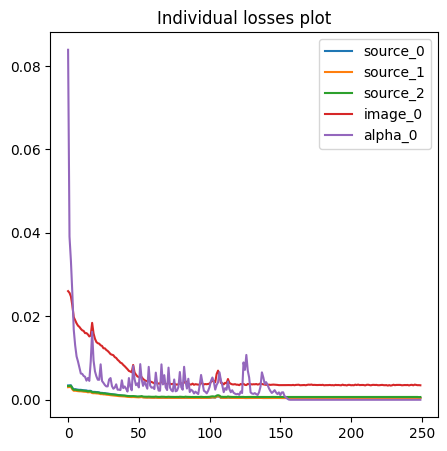

In [11]:
plot, axes = plt.subplots(1,1)
plot.set_size_inches(5,5)
for key in list(individual_losses.keys()):
    axes.plot(history_losses[key],label=key)
axes.legend()
axes.set_title('Individual losses plot')

Text(0.5, 1.0, 'Train and val losses')

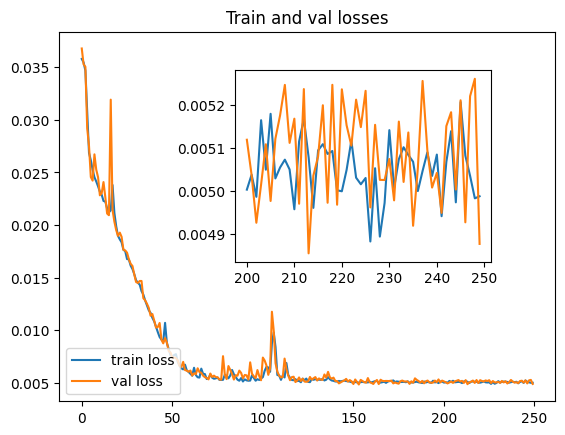

In [12]:
plot, axes = plt.subplots()
axes.plot(history['loss'],label='train loss')
axes.plot(history['val_loss'],label='val loss')
axes_2 = plot.add_axes([0.4,0.4,0.4,0.4])
axes_2.plot(range(int(0.8*EPOCHS),EPOCHS),history['loss'][int(0.8*EPOCHS):],label='train loss')
axes_2.plot(range(int(0.8*EPOCHS),EPOCHS),history['val_loss'][int(0.8*EPOCHS):],label='val loss')
axes.legend(loc='lower left')
axes.set_title('Train and val losses')

### Loading the best performing model

In [13]:
# Loads the model weights at the lowest validation score

alpha_model.load_state_dict(best_weights)
print(best_val_loss)

0.004855686293278889


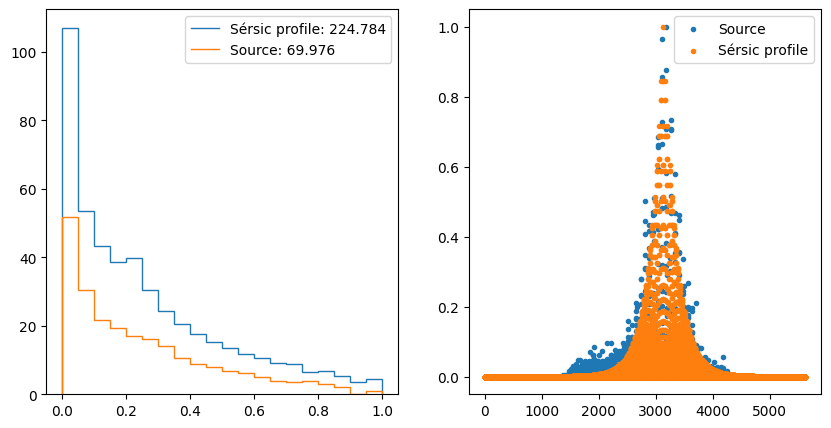

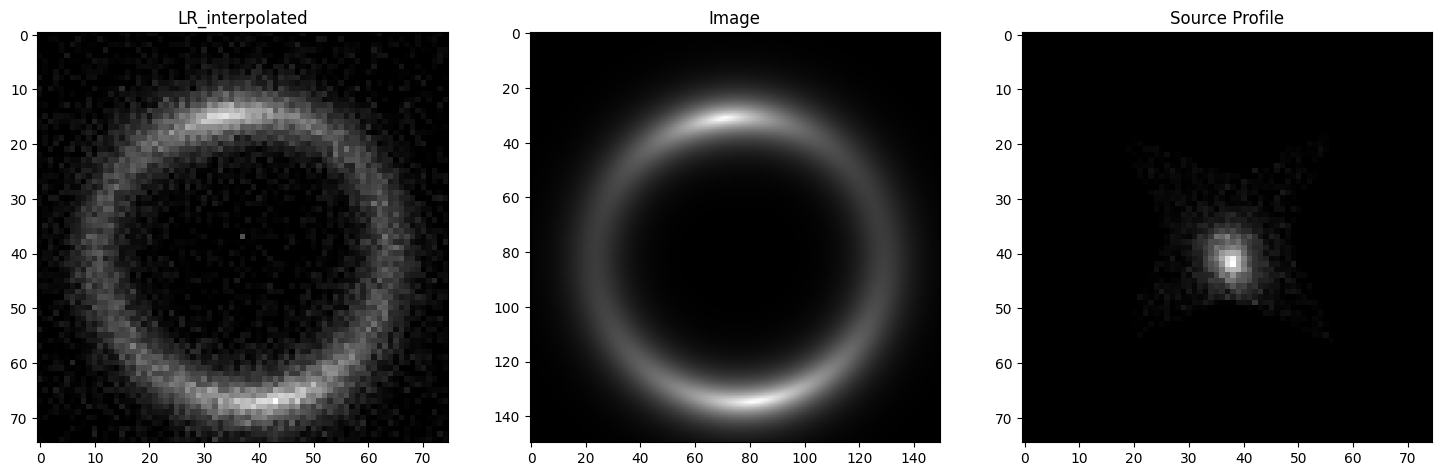

In [21]:
show_random_image(give_random_image(val_rest, alpha_model, len(val_rest)))

In [15]:
# Saves the training progress as GIFs of the reconstructed source and the super-resolved images

history['images'][0].save('images.gif',save_all=True, append_images = history['images'][1:], optimize=False, duration=100, loop=0)
history['lr'][0].save('lr.gif',save_all=True, append_images = history['lr'][1:], optimize=False, duration=100, loop=0)
history['source'][0].save('source.gif',save_all=True, append_images = history['source'][1:], optimize=False, duration=100, loop=0)

In [16]:
torch.save(best_weights, 'Weights_1.pt')